### Imports

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import glob
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from PIL import Image 
import random
import pickle

from utils import load_images
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import v2 as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms.v2 as transforms
from torchmetrics import Accuracy, F1Score, Precision, ConfusionMatrix

import matplotlib.pyplot as plt


### Preprocessing and Visualization

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

In [4]:
class Data(torch.utils.data.Dataset):
    def __init__(self, path, train = True, crop = True, augmentation = False, device = device):
        self.path = path
        self.crop = crop

        if train:
            self.data_files, self.labels = load_images(path, True)
        else:
            self.data_files, self.labels = load_images(path, False)            
        
        if augmentation:
            self.transform = transforms.Compose([
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(degrees=0,translate=(0.1, 0.1),shear=10),
            transforms.ColorJitter(brightness=(0.5, 1.5)),
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale = True),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToImage(),
                transforms.ToDtype(torch.float32, scale = True),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
            ])

    def __getitem__(self, idx):
        resized_image = None
        if self.crop:
            # Converting the image to grayscale
            gray = cv2.cvtColor(self.data_files[idx], cv2.COLOR_RGB2GRAY)
            
            # Applying Gaussian blur to smooth the image and reduce noise
            gray = cv2.GaussianBlur(gray, (5, 5), 0)

            # Thresholding the image to create a binary mask
            thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
            
            # Performing morphological operations to remove noise
            thresh = cv2.erode(thresh, None, iterations=2)
            thresh = cv2.dilate(thresh, None, iterations=2)
            
            # Finding contours in the binary mask
            contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
            if not contours:
                return self.transform(self.data_files[idx]), self.labels[idx]  # or handle the case differently
            c = max(contours, key=cv2.contourArea)
            
            # Getting the bounding rectangle of the brain part
            x, y, w, h = cv2.boundingRect(c)
            
            # Drawing contours on the original image
            contour_image = cv2.drawContours(self.data_files[idx].copy(), [c], -1, (0, 255, 0), 2)
            
            # Drawing bounding box on the original image
            bounding_box_image = cv2.rectangle(self.data_files[idx].copy(), (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            # Cropping the image around the bounding rectangle
            cropped_image = self.data_files[idx][y:y+h, x:x+w]
            
            # Resizing cropped image to the needed size
            resized_image = cv2.resize(cropped_image, (224, 224))
            resized_image = Image.fromarray(resized_image)
            
            resized_image = resized_image
            return self.transform(resized_image), self.labels[idx]
        return self.transform(self.data_files[idx]), self.labels[idx] 
    
    def __len__(self):
        return len(self.data_files)

### Baseline CNN

In [5]:
class BrainTumorClassifier(nn.Module):
    def __init__(self):
        super(BrainTumorClassifier, self).__init__()
        self.l2_reg = 0.001
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 * 14 * 14, 256)  # Adjusted output size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)  # Output a single value for binary classification
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.sigmoid(x)  # Sigmoid activation for binary classification


In [6]:
images_not_augmented = Data('brain_mri_scan_images')
images_augmented = Data('brain_mri_scan_images', augmentation = True, train = True)
test_images = Data('brain_mri_scan_images', train = False)

In [7]:
len(images_augmented)

181

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


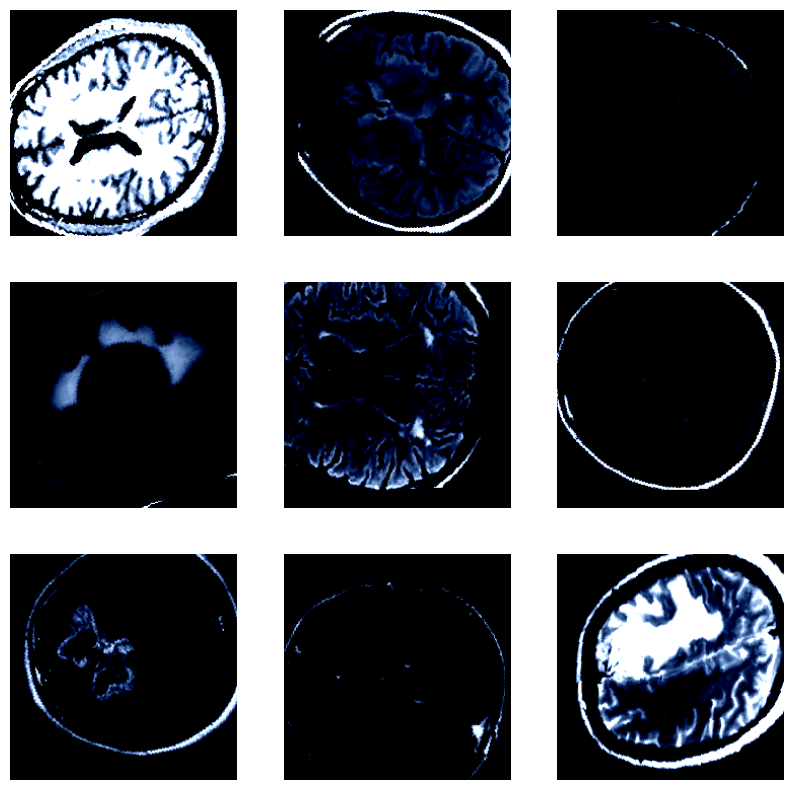

In [8]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_augmented[i][0].permute(2, 1, 0))
    plt.axis('off')
plt.show()

In [9]:
train_counts = np.unique(images_augmented.labels, return_counts = True)
test_counts = np.unique(test_images.labels, return_counts = True)

In [10]:
test_counts

(array([0, 1]), array([26, 20]))

In [ ]:
plt.bar(train_counts[0] * 8, train_counts[1] * 10)
plt.text(0, train_counts[0][0] + 0.5, 'Negativo', ha = 'center', va = 'bottom')
plt.text(1, train_counts[0][1] + 0.5, 'Positivo', ha = 'center', va = 'bottom')
plt.xlabel('Classes')
plt.title('Distribuicao de classes treinamento')
print(train_counts[0] * 8, train_counts[1] * 10)

In [ ]:
plt.bar(test_counts[0]* 6, test_counts[1] * 8)
plt.text(0, test_counts[0][0] + 0.5, 'Negativo', ha = 'center', va = 'bottom')
plt.text(1, test_counts[0][1] + 0.5, 'Positivo', ha = 'center', va = 'bottom')
plt.title('Distribuicao de classes teste')
print(test_counts[0]* 6, test_counts[1] * 8)

In [13]:
images_augmented[0][0].shape

torch.Size([3, 224, 224])

In [14]:
train_loader = torch.utils.data.DataLoader(images_not_augmented, batch_size = 16, num_workers = 4)
train_loader_augmented = torch.utils.data.DataLoader(images_augmented, batch_size = 16, num_workers = 4)
test_loader = torch.utils.data.DataLoader(test_images, batch_size = 16, num_workers = 4)

In [15]:
acc = Accuracy('multiclass', num_classes = 2).to(device)

In [16]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if val_loss < self.val_loss_min:
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
            torch.save(model.state_dict(), 'checkpoint.pt')
            self.val_loss_min = val_loss


### Training

In [17]:
def train_step(model, train_loader, criterion, optimizer, acc, f1score, precision, confusion_matrix, device):
  model.train()
  train_loss = 0
  train_acc = 0
  train_f1 = 0
  train_precision = 0
  train_confusion = torch.zeros((2, 2)).to(device)

  for batch, (X, y) in enumerate(train_loader):
    X, y = X.to(device), y.to(device).float()
    y_preds = model(X).squeeze()
    loss = criterion(y_preds, y)
    train_loss += loss.item()

    y_preds_bin = (y_preds >= 0.5).float()

    train_acc += acc(y_preds_bin, y).item()
    train_f1 += f1score(y_preds_bin, y).item()
    train_precision += precision(y_preds_bin, y).float().mean().item()
    train_confusion += confusion_matrix(y_preds_bin, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(train_loader)
  train_acc /= len(train_loader)
  train_f1 /= len(train_loader)
  train_precision /= len(train_loader)

  print(f'Train Loss:{train_loss}, Train Acc:{train_acc}, Train_f1:{train_f1}, train_precision:{train_precision}', end = ', ')
  return train_loss, train_acc, train_f1, train_precision, train_confusion

def test_step(model, test_loader, criterion, acc, f1score, precision, confusion_matrix, device):
  test_loss = 0
  test_acc = 0
  test_f1 = 0
  test_precision = 0
  test_confusion = torch.zeros((2, 2)).to(device)

  model.eval()
  with torch.inference_mode():
    for X, y in test_loader:
      X, y = X.to(device), y.to(device).float()
      y_preds = model(X).squeeze()
      test_loss += criterion(y_preds, y).item()

      y_preds_bin = (y_preds >= 0.5).float()

      test_acc += acc(y_preds_bin, y).item()
      test_f1 += f1score(y_preds_bin, y).item()
      test_precision += precision(y_preds_bin, y).float().mean().item()
      test_confusion += confusion_matrix(y_preds_bin, y)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    test_f1 /= len(test_loader)
    test_precision /= len(test_loader)

  print(f'Test Loss:{test_loss}, Test Acc:{test_acc},  Test_f1:{test_f1}, train_precision:{test_precision}')
  return test_loss, test_acc, test_f1, test_precision, test_confusion

def validation_step(model, val_dl, loss_fn, device):
  # ativar modo de avaliação
  model.eval()

  val_los = 0
  # desativar computação de gradientes
  with torch.no_grad():
    for val_instances, instance_labels in val_dl:
      # mover o lote e os rotulos para o mesmo dispositivo do modelo
      val_instances = val_instances.to(device)
      instance_labels = instance_labels.to(device)

      # fazer previsão com o modelo
      logits = model(val_instances)

      # calcular função de perda
      loss = loss_fn(logits, instance_labels)
      val_loss += loss.item()
  val_loss /= len(val_df)
  return val_loss  

   

In [18]:
def workflow(model, train_loader, test_loader, criterion, optimizer, acc, f1score, precision, confusion_matrix, device, epochs = 10):
    train_losses, train_accs, test_losses, test_accs = [], [], [], []
    train_f1s, train_precisions, test_f1s, test_precisions = [], [], [], []
    train_confusions, test_confusions = torch.zeros((2, 2)).to(device), torch.zeros((2, 2)).to(device)
    early_stopping = EarlyStopping(patience=10, verbose=True)
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_f1, train_precision, train_confusion = train_step(model, train_loader, criterion, optimizer, f1score, precision, confusion_matrix,acc, device)
        train_losses.append(train_loss), train_accs.append(train_acc)
        train_f1s.append(train_f1), train_precisions.append(train_precision)
        train_confusions += train_confusion
        test_loss, test_acc, test_f1, test_precision, test_confusion = test_step(model, test_loader, criterion, acc, f1score, precision, confusion_matrix, device)
        test_losses.append(test_loss), test_accs.append(test_acc)
        test_f1s.append(test_f1), test_precisions.append(test_precision)
        test_confusions += test_confusion

        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping.")
            break
    return train_losses, train_accs, train_f1s, train_precisions, train_confusion, test_losses, test_accs, test_f1s, test_precisions, test_confusion

In [19]:
model = BrainTumorClassifier().to(device)

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
criterion = nn.BCELoss().to(device)
acc = Accuracy('binary', num_classes = 2).to(device)
f1score = F1Score('binary', num_classes = 2).to(device)
precision = Precision('binary', num_classes = 2).to(device)
confusion_matrix = ConfusionMatrix('binary', num_classes = 2).to(device)

In [21]:
baseline_train_losses, baseline_train_accs, baseline_train_f1s, baseline_train_precisions, baseline_train_confusion, baseline_test_losses, baseline_test_accs, baseline_test_f1s, baseline_test_precisions, baseline_test_confusion = workflow(model, train_loader, test_loader, criterion, optimizer, acc, f1score, precision, confusion_matrix, device, 50)
baseline_aug_train_losses, baseline_aug_train_accs, baseline_aug_train_f1s, baseline_aug_train_precisions, baseline_aug_train_confusion, baseline_aug_test_losses, baseline_aug_test_accs, baseline_aug_test_f1s, baseline_aug_test_precisions, baseline_aug_test_confusion = workflow(model, train_loader, test_loader, criterion, optimizer, acc, f1score, precision, confusion_matrix, device, 50)

  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:42.039833982785545, Train Acc:0.6642804766694704, Train_f1:0.538541667163372, train_precision:3.7708333333333335, 

  2%|▏         | 1/50 [00:02<01:56,  2.38s/it]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Validation loss decreased (inf --> 55.357143). Saving model...
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

  4%|▍         | 2/50 [00:03<01:11,  1.49s/it]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

  6%|▌         | 3/50 [00:04<00:57,  1.23s/it]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

  8%|▊         | 4/50 [00:05<00:49,  1.08s/it]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 10%|█         | 5/50 [00:05<00:44,  1.00it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 12%|█▏        | 6/50 [00:06<00:42,  1.05it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 14%|█▍        | 7/50 [00:07<00:39,  1.08it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 16%|█▌        | 8/50 [00:08<00:38,  1.10it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 18%|█▊        | 9/50 [00:09<00:37,  1.09it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 20%|██        | 10/50 [00:10<00:35,  1.12it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 22%|██▏       | 11/50 [00:11<00:34,  1.14it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 24%|██▍       | 12/50 [00:11<00:33,  1.15it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043


 26%|██▌       | 13/50 [00:12<00:31,  1.16it/s]

Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 28%|██▊       | 14/50 [00:13<00:30,  1.17it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 30%|███       | 15/50 [00:14<00:30,  1.16it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 32%|███▏      | 16/50 [00:15<00:29,  1.15it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 34%|███▍      | 17/50 [00:16<00:28,  1.16it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 36%|███▌      | 18/50 [00:17<00:27,  1.15it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 38%|███▊      | 19/50 [00:17<00:26,  1.16it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 40%|████      | 20/50 [00:18<00:25,  1.16it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 42%|████▏     | 21/50 [00:19<00:25,  1.16it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 44%|████▍     | 22/50 [00:20<00:24,  1.16it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 46%|████▌     | 23/50 [00:21<00:23,  1.15it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 48%|████▊     | 24/50 [00:22<00:22,  1.16it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043


 50%|█████     | 25/50 [00:23<00:21,  1.16it/s]

Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 52%|█████▏    | 26/50 [00:24<00:20,  1.16it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 54%|█████▍    | 27/50 [00:24<00:19,  1.17it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 56%|█████▌    | 28/50 [00:25<00:18,  1.16it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 58%|█████▊    | 29/50 [00:26<00:17,  1.17it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 60%|██████    | 30/50 [00:27<00:17,  1.16it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 62%|██████▏   | 31/50 [00:28<00:16,  1.17it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 64%|██████▍   | 32/50 [00:29<00:15,  1.17it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 66%|██████▌   | 33/50 [00:29<00:14,  1.17it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 68%|██████▊   | 34/50 [00:30<00:13,  1.17it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:45.104166666666664, Train Acc:0.7045735170443853, Train_f1:0.5489583338300387, train_precision:3.7708333333333335, 

 70%|███████   | 35/50 [00:31<00:12,  1.18it/s]

Test Loss:55.35714340209961, Test Acc:0.4464285771052043,  Test_f1:0.5952380895614624, train_precision:0.4464285771052043
Train Loss:13.951627065738043, Train Acc:0.6650297194719315, Train_f1:0.6564206679662069, train_precision:3.7708333333333335, Test Loss:37.13226509094238, Test Acc:0.5952380895614624,  Test_f1:0.6417069236437479, train_precision:0.5058275163173676
Validation loss decreased (55.357143 --> 37.132265). Saving model...


 72%|███████▏  | 36/50 [00:32<00:12,  1.11it/s]

Train Loss:7.017917647957802, Train Acc:0.7078801194826762, Train_f1:0.7009032716353735, train_precision:3.7708333333333335, 

 74%|███████▍  | 37/50 [00:33<00:12,  1.05it/s]

Test Loss:26.325741449991863, Test Acc:0.5565476218859354,  Test_f1:0.6285663843154907, train_precision:0.5012210011482239
Validation loss decreased (37.132265 --> 26.325741). Saving model...
Train Loss:6.84379933650295, Train Acc:0.7526394079128901, Train_f1:0.7351724753777186, train_precision:3.7708333333333335, 

 76%|███████▌  | 38/50 [00:34<00:11,  1.02it/s]

Test Loss:9.89095656077067, Test Acc:0.7589285771052042,  Test_f1:0.7452991604804993, train_precision:0.6654762029647827
Validation loss decreased (26.325741 --> 9.890957). Saving model...
Train Loss:7.13232768792659, Train Acc:0.7780094891786575, Train_f1:0.7540193647146225, train_precision:3.7708333333333335, Test Loss:1.5850964784622192, Test Acc:0.705357144276301,  Test_f1:0.5185185273488363, train_precision:1.0
Validation loss decreased (9.890957 --> 1.585096). Saving model...


 78%|███████▊  | 39/50 [00:35<00:11,  1.01s/it]

Train Loss:6.108967221031587, Train Acc:0.8058629781007767, Train_f1:0.8062049051125845, train_precision:3.7708333333333335, 

 80%|████████  | 40/50 [00:36<00:09,  1.04it/s]

Test Loss:5.733152071634929, Test Acc:0.800595243771871,  Test_f1:0.786868691444397, train_precision:0.7269841432571411
EarlyStopping counter: 1 out of 10
Train Loss:4.29555023709933, Train Acc:0.7498804653684298, Train_f1:0.7510582084457079, train_precision:3.7708333333333335, 

 82%|████████▏ | 41/50 [00:37<00:08,  1.02it/s]

Test Loss:0.5753000477949778, Test Acc:0.7440476218859354,  Test_f1:0.749458889166514, train_precision:0.6144781212011973
Validation loss decreased (1.585096 --> 0.575300). Saving model...
Train Loss:2.6693925565729537, Train Acc:0.7424662684400877, Train_f1:0.806969886024793, train_precision:3.7708333333333335, 

 84%|████████▍ | 42/50 [00:38<00:08,  1.00s/it]

Test Loss:0.31352941195170086, Test Acc:0.8660714228947958,  Test_f1:0.8300653696060181, train_precision:0.9166666666666666
Validation loss decreased (0.575300 --> 0.313529). Saving model...
Train Loss:2.6566997903088727, Train Acc:0.8124105284611384, Train_f1:0.8166666726271311, train_precision:3.7708333333333335, Test Loss:0.3562212586402893, Test Acc:0.8660714228947958,  Test_f1:0.827540119489034, train_precision:0.9444444378217062


 86%|████████▌ | 43/50 [00:39<00:06,  1.04it/s]

EarlyStopping counter: 1 out of 10
Train Loss:1.6068298934648435, Train Acc:0.7556411276261011, Train_f1:0.8901996165513992, train_precision:3.7708333333333335, 

 88%|████████▊ | 44/50 [00:40<00:05,  1.07it/s]

Test Loss:0.47751859823862713, Test Acc:0.8184523781140646,  Test_f1:0.7986443440119425, train_precision:0.8703703681627909
EarlyStopping counter: 2 out of 10
Train Loss:1.9920588297148545, Train Acc:0.8281789347529411, Train_f1:0.8427459125717481, train_precision:3.7708333333333335, 

 90%|█████████ | 45/50 [00:41<00:04,  1.09it/s]

Test Loss:0.3635440468788147, Test Acc:0.886904756228129,  Test_f1:0.8578431407610575, train_precision:1.0
EarlyStopping counter: 3 out of 10
Train Loss:1.4125137366354465, Train Acc:0.8853282928466797, Train_f1:0.9371632983287176, train_precision:3.7708333333333335, 

 92%|█████████▏| 46/50 [00:42<00:03,  1.12it/s]

Test Loss:0.3284726043542226, Test Acc:0.886904756228129,  Test_f1:0.8738364179929098, train_precision:0.9444444378217062
EarlyStopping counter: 4 out of 10
Train Loss:1.4049973239501317, Train Acc:0.8752040714025497, Train_f1:0.8808140953381857, train_precision:3.7708333333333335, 

 94%|█████████▍| 47/50 [00:43<00:02,  1.14it/s]

Test Loss:0.31666210293769836, Test Acc:0.8839285771052042,  Test_f1:0.8796296318372091, train_precision:1.0
EarlyStopping counter: 5 out of 10
Train Loss:0.5329678691923618, Train Acc:0.8441760092973709, Train_f1:0.9116071412960688, train_precision:3.7708333333333335, 

 96%|█████████▌| 48/50 [00:44<00:01,  1.06it/s]

Test Loss:0.29297374685605365, Test Acc:0.886904756228129,  Test_f1:0.8738364179929098, train_precision:0.9444444378217062
Validation loss decreased (0.313529 --> 0.292974). Saving model...
Train Loss:0.8532590220371882, Train Acc:0.9040617644786835, Train_f1:0.9259469707806905, train_precision:3.7708333333333335, 

 98%|█████████▊| 49/50 [00:45<00:00,  1.09it/s]

Test Loss:0.29887810349464417, Test Acc:0.9077380895614624,  Test_f1:0.9041394392649332, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.8920154849377772, Train Acc:0.8513750980297724, Train_f1:0.9019059638182322, train_precision:3.7708333333333335, 

100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


Test Loss:0.29779215653737384, Test Acc:0.9077380895614624,  Test_f1:0.9041394392649332, train_precision:1.0
EarlyStopping counter: 2 out of 10


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:0.3926574820652604, Train Acc:0.8461161851882935, Train_f1:0.8856481462717056, train_precision:3.7708333333333335, 

  2%|▏         | 1/50 [00:01<00:51,  1.05s/it]

Test Loss:0.34281235933303833, Test Acc:0.8214285771052042,  Test_f1:0.811965823173523, train_precision:0.8333333333333334
Validation loss decreased (inf --> 0.342812). Saving model...
Train Loss:0.3893430468936761, Train Acc:0.8890181630849838, Train_f1:0.9270412425200144, train_precision:3.7708333333333335, Test Loss:0.3127809266249339, Test Acc:0.8660714228947958,  Test_f1:0.8485838770866394, train_precision:0.9047619104385376
Validation loss decreased (0.342812 --> 0.312781). Saving model...


  4%|▍         | 2/50 [00:02<00:50,  1.04s/it]

Train Loss:0.2847977752486865, Train Acc:0.8867022842168808, Train_f1:0.8862644284963608, train_precision:3.7708333333333335, 

  6%|▌         | 3/50 [00:03<00:50,  1.08s/it]

Test Loss:0.2833639631668727, Test Acc:0.9077380895614624,  Test_f1:0.9041394392649332, train_precision:1.0
Validation loss decreased (0.312781 --> 0.283364). Saving model...
Train Loss:0.3065455798059702, Train Acc:0.8992286324501038, Train_f1:0.936769480506579, train_precision:3.7708333333333335, 

  8%|▊         | 4/50 [00:04<00:45,  1.01it/s]

Test Loss:0.28860857089360553, Test Acc:0.9077380895614624,  Test_f1:0.9041394392649332, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.27703006907055777, Train Acc:0.9269213179747263, Train_f1:0.923800508181254, train_precision:3.7708333333333335, 

 10%|█         | 5/50 [00:04<00:42,  1.06it/s]

Test Loss:0.28972792625427246, Test Acc:0.9077380895614624,  Test_f1:0.9041394392649332, train_precision:1.0
EarlyStopping counter: 2 out of 10
Train Loss:0.2376104717453321, Train Acc:0.9050196955601374, Train_f1:0.9029671748479208, train_precision:3.7708333333333335, Test Loss:0.2555007537206014, Test Acc:0.886904756228129,  Test_f1:0.8738364179929098, train_precision:0.9444444378217062

 12%|█▏        | 6/50 [00:05<00:42,  1.02it/s]


Validation loss decreased (0.283364 --> 0.255501). Saving model...
Train Loss:0.24095065612345934, Train Acc:0.905396526058515, Train_f1:0.936111107468605, train_precision:3.7708333333333335, 

 14%|█▍        | 7/50 [00:07<00:42,  1.00it/s]

Test Loss:0.23932746549447378, Test Acc:0.9315476218859354,  Test_f1:0.9259259303410848, train_precision:1.0
Validation loss decreased (0.255501 --> 0.239327). Saving model...
Train Loss:0.19020967542504272, Train Acc:0.9449832687775294, Train_f1:0.9553240736325582, train_precision:3.7708333333333335, 

 16%|█▌        | 8/50 [00:08<00:43,  1.04s/it]

Test Loss:0.21347433825333914, Test Acc:0.886904756228129,  Test_f1:0.8738364179929098, train_precision:0.9444444378217062
Validation loss decreased (0.239327 --> 0.213474). Saving model...
Train Loss:0.2122448186079661, Train Acc:0.9320725351572037, Train_f1:0.9228745897610983, train_precision:3.7708333333333335, 

 18%|█▊        | 9/50 [00:08<00:40,  1.02it/s]

Test Loss:0.2183182736237844, Test Acc:0.8660714228947958,  Test_f1:0.8485838770866394, train_precision:0.9047619104385376
EarlyStopping counter: 1 out of 10
Train Loss:0.20884821889922023, Train Acc:0.923115869363149, Train_f1:0.9485058983167013, train_precision:3.7708333333333335, 

 20%|██        | 10/50 [00:10<00:39,  1.00it/s]

Test Loss:0.20316185305515924, Test Acc:0.9077380895614624,  Test_f1:0.9041394392649332, train_precision:1.0
Validation loss decreased (0.213474 --> 0.203162). Saving model...
Train Loss:0.21576874889433384, Train Acc:0.904849037528038, Train_f1:0.910774419705073, train_precision:3.7708333333333335, Test Loss:0.19993442048629126, Test Acc:0.9315476218859354,  Test_f1:0.9326599438985189, train_precision:0.9444444378217062
Validation loss decreased (0.203162 --> 0.199934). Saving model...


 22%|██▏       | 11/50 [00:11<00:39,  1.00s/it]

Train Loss:0.21951778729756674, Train Acc:0.9031989375750223, Train_f1:0.9544434746106466, train_precision:3.7708333333333335, 

 24%|██▍       | 12/50 [00:11<00:36,  1.03it/s]

Test Loss:0.24203636248906454, Test Acc:0.9077380895614624,  Test_f1:0.9041394392649332, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.15805184841156006, Train Acc:0.9506327112515768, Train_f1:0.9776785721381506, train_precision:3.7708333333333335, 

 26%|██▌       | 13/50 [00:12<00:35,  1.04it/s]

Test Loss:0.2115933895111084, Test Acc:0.886904756228129,  Test_f1:0.8738364179929098, train_precision:0.9444444378217062
EarlyStopping counter: 2 out of 10
Train Loss:0.17554068689544997, Train Acc:0.9401566286881765, Train_f1:0.9551557252804438, train_precision:3.7708333333333335, 

 28%|██▊       | 14/50 [00:13<00:35,  1.02it/s]

Test Loss:0.179842176536719, Test Acc:0.9285714228947958,  Test_f1:0.9411764740943909, train_precision:1.0
Validation loss decreased (0.199934 --> 0.179842). Saving model...
Train Loss:0.20580757906039557, Train Acc:0.9301668504873911, Train_f1:0.9359066883722941, train_precision:3.7708333333333335, 

 30%|███       | 15/50 [00:14<00:33,  1.05it/s]

Test Loss:0.20309538642565408, Test Acc:0.9077380895614624,  Test_f1:0.9108734528223673, train_precision:0.9444444378217062
EarlyStopping counter: 1 out of 10
Train Loss:0.20661598273242512, Train Acc:0.9333295126756033, Train_f1:0.9634890606005987, train_precision:3.7708333333333335, 

 32%|███▏      | 16/50 [00:15<00:31,  1.08it/s]

Test Loss:0.19525042672952017, Test Acc:0.9315476218859354,  Test_f1:0.9326599438985189, train_precision:0.9444444378217062
EarlyStopping counter: 2 out of 10
Train Loss:0.21899738407228142, Train Acc:0.9231905490159988, Train_f1:0.9484427670637766, train_precision:3.7708333333333335, 

 34%|███▍      | 17/50 [00:16<00:30,  1.10it/s]

Test Loss:0.18162667254606882, Test Acc:0.9315476218859354,  Test_f1:0.9326599438985189, train_precision:0.9444444378217062
EarlyStopping counter: 3 out of 10
Train Loss:0.2186956238001585, Train Acc:0.9234700004259745, Train_f1:0.937394787867864, train_precision:3.7708333333333335, 

 36%|███▌      | 18/50 [00:17<00:30,  1.05it/s]

Test Loss:0.16685378551483154, Test Acc:0.9523809552192688,  Test_f1:0.9629629651705424, train_precision:1.0
Validation loss decreased (0.179842 --> 0.166854). Saving model...
Train Loss:0.14895871731763086, Train Acc:0.9505507797002792, Train_f1:0.9916666646798452, train_precision:3.7708333333333335, 

 38%|███▊      | 19/50 [00:18<00:28,  1.08it/s]

Test Loss:0.22204548120498657, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
EarlyStopping counter: 1 out of 10
Train Loss:0.29471338478227455, Train Acc:0.9167853246132532, Train_f1:0.9311447888612747, train_precision:3.7708333333333335, 

 40%|████      | 20/50 [00:19<00:27,  1.10it/s]

Test Loss:0.1949071908990542, Test Acc:0.9523809552192688,  Test_f1:0.9629629651705424, train_precision:1.0
EarlyStopping counter: 2 out of 10
Train Loss:0.1549418450643619, Train Acc:0.9661341905593872, Train_f1:0.9803240746259689, train_precision:3.7708333333333335, 

 42%|████▏     | 21/50 [00:20<00:27,  1.05it/s]

Test Loss:0.16024373223384222, Test Acc:0.9315476218859354,  Test_f1:0.9326599438985189, train_precision:0.9444444378217062
Validation loss decreased (0.166854 --> 0.160244). Saving model...
Train Loss:0.1805587433433781, Train Acc:0.9464052269856135, Train_f1:0.9600859781106313, train_precision:3.7708333333333335, 

 44%|████▍     | 22/50 [00:21<00:27,  1.01it/s]

Test Loss:0.1467419465382894, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
Validation loss decreased (0.160244 --> 0.146742). Saving model...
Train Loss:0.1621008776128292, Train Acc:0.9592232803503672, Train_f1:0.9510582039753596, train_precision:3.7708333333333335, 

 46%|████▌     | 23/50 [00:22<00:27,  1.01s/it]

Test Loss:0.13035059223572412, Test Acc:0.976190467675527,  Test_f1:0.9824561476707458, train_precision:1.0
Validation loss decreased (0.146742 --> 0.130351). Saving model...
Train Loss:0.1316835880279541, Train Acc:0.9439924856026968, Train_f1:0.948211282491684, train_precision:3.7708333333333335, 

 48%|████▊     | 24/50 [00:23<00:25,  1.02it/s]

Test Loss:0.1313504638771216, Test Acc:0.976190467675527,  Test_f1:0.9824561476707458, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.13459618195580939, Train Acc:0.9506915460030237, Train_f1:0.9497685184081396, train_precision:3.7708333333333335, 

 50%|█████     | 25/50 [00:24<00:23,  1.07it/s]

Test Loss:0.14017405981818834, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
EarlyStopping counter: 2 out of 10
Train Loss:0.12435174857576688, Train Acc:0.9619723012049993, Train_f1:0.9694444437821707, train_precision:3.7708333333333335, 

 52%|█████▏    | 26/50 [00:25<00:21,  1.10it/s]

Test Loss:0.14990320801734924, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
EarlyStopping counter: 3 out of 10
Train Loss:0.2037429011737307, Train Acc:0.949546217918396, Train_f1:0.9404040426015854, train_precision:3.7708333333333335, 

 54%|█████▍    | 27/50 [00:25<00:20,  1.11it/s]

Test Loss:0.1643510436018308, Test Acc:0.9791666666666666,  Test_f1:0.9696969787279764, train_precision:0.9444444378217062
EarlyStopping counter: 4 out of 10
Train Loss:0.2440977618098259, Train Acc:0.9401366660992304, Train_f1:0.9494949529568354, train_precision:3.7708333333333335, 

 56%|█████▌    | 28/50 [00:26<00:19,  1.13it/s]

Test Loss:0.16047385955850282, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
EarlyStopping counter: 5 out of 10
Train Loss:0.15974444174207747, Train Acc:0.9482802699009577, Train_f1:0.9381944487492243, train_precision:3.7708333333333335, 

 58%|█████▊    | 29/50 [00:27<00:18,  1.12it/s]

Test Loss:0.14386008183161417, Test Acc:0.9077380895614624,  Test_f1:0.9108734528223673, train_precision:0.9444444378217062
EarlyStopping counter: 6 out of 10
Train Loss:0.1483881201905509, Train Acc:0.9247721135616302, Train_f1:0.9646464685599009, train_precision:3.7708333333333335, 

 60%|██████    | 30/50 [00:28<00:18,  1.05it/s]

Test Loss:0.12749821692705154, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
Validation loss decreased (0.130351 --> 0.127498). Saving model...
Train Loss:0.1652906835079193, Train Acc:0.9458195467789968, Train_f1:0.9582972576220831, train_precision:3.7708333333333335, 

 62%|██████▏   | 31/50 [00:29<00:17,  1.08it/s]

Test Loss:0.17271363735198975, Test Acc:0.976190467675527,  Test_f1:0.9824561476707458, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.15764914949735007, Train Acc:0.954618846376737, Train_f1:0.9442760944366455, train_precision:3.7708333333333335, 

 64%|██████▍   | 32/50 [00:30<00:17,  1.05it/s]

Test Loss:0.12149659792582194, Test Acc:0.9523809552192688,  Test_f1:0.9629629651705424, train_precision:1.0
Validation loss decreased (0.127498 --> 0.121497). Saving model...
Train Loss:0.15173794329166412, Train Acc:0.9449047098557154, Train_f1:0.9666666636864344, train_precision:3.7708333333333335, 

 66%|██████▌   | 33/50 [00:31<00:15,  1.08it/s]

Test Loss:0.13612457861502966, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
EarlyStopping counter: 1 out of 10
Train Loss:0.12747854685100415, Train Acc:0.9678153743346533, Train_f1:0.957007572054863, train_precision:3.7708333333333335, 

 68%|██████▊   | 34/50 [00:32<00:15,  1.03it/s]

Test Loss:0.10075543510417144, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
Validation loss decreased (0.121497 --> 0.100755). Saving model...
Train Loss:0.14714789856225252, Train Acc:0.9668033470710119, Train_f1:0.9736742426951727, train_precision:3.7708333333333335, 

 70%|███████   | 35/50 [00:33<00:15,  1.00s/it]

Test Loss:0.09496687104304631, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
Validation loss decreased (0.100755 --> 0.094967). Saving model...
Train Loss:0.09061660974596937, Train Acc:0.9622220496336619, Train_f1:0.9657407402992249, train_precision:3.7708333333333335, 

 72%|███████▏  | 36/50 [00:34<00:13,  1.03it/s]

Test Loss:0.14040782675147057, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
EarlyStopping counter: 1 out of 10
Train Loss:0.25170114015539485, Train Acc:0.9223623722791672, Train_f1:0.9144420474767685, train_precision:3.7708333333333335, 

 74%|███████▍  | 37/50 [00:35<00:12,  1.07it/s]

Test Loss:0.14335281029343605, Test Acc:0.9315476218859354,  Test_f1:0.9326599438985189, train_precision:0.9444444378217062
EarlyStopping counter: 2 out of 10
Train Loss:0.167256363046666, Train Acc:0.9520137707392374, Train_f1:0.9762205431858698, train_precision:3.7708333333333335, 

 76%|███████▌  | 38/50 [00:36<00:10,  1.10it/s]

Test Loss:0.28189199169476825, Test Acc:0.824404756228129,  Test_f1:0.841269850730896, train_precision:0.7727272709210714
EarlyStopping counter: 3 out of 10
Train Loss:0.16478750412352383, Train Acc:0.9495596339305242, Train_f1:0.9663299719492594, train_precision:3.7708333333333335, 

 78%|███████▊  | 39/50 [00:37<00:09,  1.12it/s]

Test Loss:0.1251997910439968, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
EarlyStopping counter: 4 out of 10
Train Loss:0.14342117542400956, Train Acc:0.9456315437952677, Train_f1:0.9600859781106313, train_precision:3.7708333333333335, 

 80%|████████  | 40/50 [00:38<00:09,  1.06it/s]

Test Loss:0.09233677387237549, Test Acc:0.976190467675527,  Test_f1:0.9824561476707458, train_precision:1.0
Validation loss decreased (0.094967 --> 0.092337). Saving model...
Train Loss:0.110912817530334, Train Acc:0.9695611596107483, Train_f1:0.972748319307963, train_precision:3.7708333333333335, 

 82%|████████▏ | 41/50 [00:39<00:08,  1.08it/s]

Test Loss:0.14699424554904303, Test Acc:0.976190467675527,  Test_f1:0.9824561476707458, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.1528791794553399, Train Acc:0.959946388999621, Train_f1:0.9618055572112402, train_precision:3.7708333333333335, 

 84%|████████▍ | 42/50 [00:39<00:07,  1.11it/s]

Test Loss:0.12925914178291956, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
EarlyStopping counter: 2 out of 10
Train Loss:0.08455146247676264, Train Acc:0.981951043009758, Train_f1:0.9854798018932343, train_precision:3.7708333333333335, 

 86%|████████▌ | 43/50 [00:40<00:06,  1.11it/s]

Test Loss:0.1352334295709928, Test Acc:0.976190467675527,  Test_f1:0.9824561476707458, train_precision:1.0
EarlyStopping counter: 3 out of 10
Train Loss:0.08143623254727572, Train Acc:0.9711893101533254, Train_f1:0.9791666666666666, train_precision:3.7708333333333335, 

 88%|████████▊ | 44/50 [00:41<00:05,  1.12it/s]

Test Loss:0.15543283770481744, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
EarlyStopping counter: 4 out of 10
Train Loss:0.10653914866270497, Train Acc:0.9501620431741079, Train_f1:0.9370370358228683, train_precision:3.7708333333333335, 

 90%|█████████ | 45/50 [00:42<00:04,  1.11it/s]

Test Loss:0.1599439469476541, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
EarlyStopping counter: 5 out of 10
Train Loss:0.07649045833386481, Train Acc:0.9831649859746298, Train_f1:0.9757575790087382, train_precision:3.7708333333333335, 

 92%|█████████▏| 46/50 [00:43<00:03,  1.11it/s]

Test Loss:0.1654267938186725, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
EarlyStopping counter: 6 out of 10
Train Loss:0.17390989578173807, Train Acc:0.9692934801181158, Train_f1:0.9548611144224802, train_precision:3.7708333333333335, 

 94%|█████████▍| 47/50 [00:44<00:02,  1.13it/s]

Test Loss:0.09860605498154958, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
EarlyStopping counter: 7 out of 10
Train Loss:0.21182674889375144, Train Acc:0.9453015426794688, Train_f1:0.9739057272672653, train_precision:3.7708333333333335, 

 96%|█████████▌| 48/50 [00:45<00:01,  1.13it/s]

Test Loss:0.11650167405605316, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
EarlyStopping counter: 8 out of 10
Train Loss:0.08313804673283205, Train Acc:0.9768309692541758, Train_f1:0.9803240746259689, train_precision:3.7708333333333335, 

 98%|█████████▊| 49/50 [00:46<00:00,  1.13it/s]

Test Loss:0.1326497532427311, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
EarlyStopping counter: 9 out of 10
Train Loss:0.10918394196778536, Train Acc:0.9625141322612762, Train_f1:0.9814814825852712, train_precision:3.7708333333333335, 

 98%|█████████▊| 49/50 [00:46<00:00,  1.04it/s]

Test Loss:0.10000692059596379, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
EarlyStopping counter: 10 out of 10
Early stopping.


In [22]:
import matplotlib.pyplot as plt

def plot_graphs_scalar_metrics(nome_do_modelo, baseline_train_losses, baseline_test_losses, baseline_train_accs, baseline_test_accs, baseline_train_f1s, baseline_test_f1s, baseline_train_precisions, baseline_test_precisions):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))  # Set the figure size directly in subplots
    
    ax[0, 0].plot(range(len(baseline_train_losses)), baseline_train_losses, label='Treino')
    ax[0, 0].plot(range(len(baseline_test_losses)), baseline_test_losses, label='Teste')
    ax[0, 0].set_title('Losses')
    ax[0, 0].legend()
    
    ax[0, 1].plot(range(len(baseline_train_accs)), baseline_train_accs, label='Treino')
    ax[0, 1].plot(range(len(baseline_test_accs)), baseline_test_accs, label='Teste')
    ax[0, 1].set_title('Accuracy')
    ax[0, 1].legend()
    
    ax[1, 0].plot(range(len(baseline_train_f1s)), baseline_train_f1s, label='Treino')
    ax[1, 0].plot(range(len(baseline_test_f1s)), baseline_test_f1s, label='Teste')
    ax[1, 0].set_title('F1 Score')
    ax[1, 0].legend()
    
    ax[1, 1].plot(range(len(baseline_train_precisions)), baseline_train_precisions, label='Treino')
    ax[1, 1].plot(range(len(baseline_test_precisions)), baseline_test_precisions, label='Teste')
    ax[1, 1].set_title('Precision')
    ax[1, 1].legend()

    fig.suptitle('Métricas', fontsize=14)
    
    
    fig.show() 


In [23]:
def plot_confusion(nome_do_modelo, baseline_train_confusion, baseline_test_confusion):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))  # Adjusted figure size

    # Plotting the heatmaps
    sns.heatmap(baseline_train_confusion.to('cpu').detach().numpy(), annot=True, ax=ax[0])
    ax[0].set_title('Confusion Matrix - Train')
    
    sns.heatmap(baseline_test_confusion.to('cpu').detach().numpy(), annot=True, ax=ax[1])
    ax[1].set_title('Confusion Matrix - Test')

    # Save the figure
    plt.savefig(f'{nome_do_modelo}_confusion.png')
    plt.plot() # Close the figure to free memory


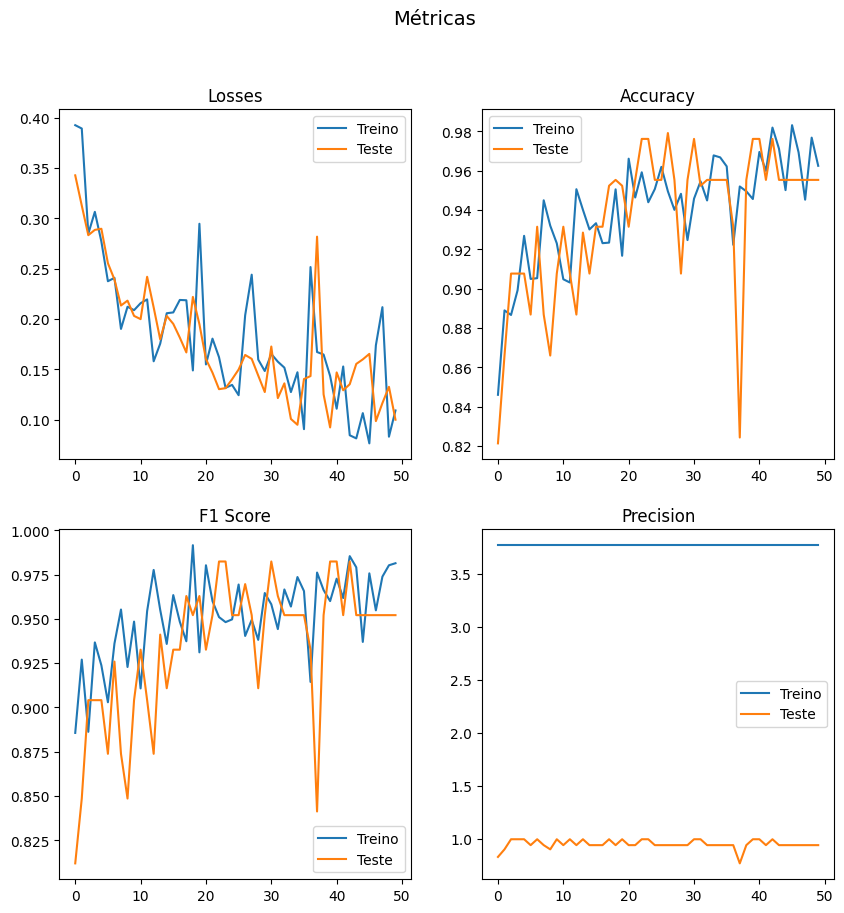

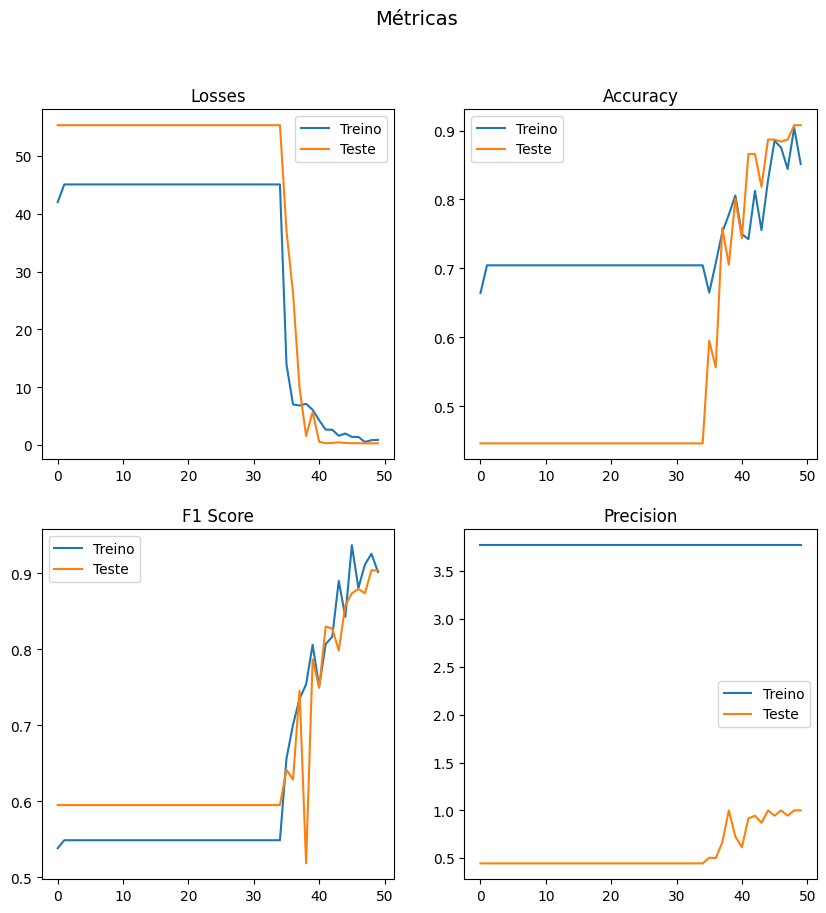

In [24]:

plot_graphs_scalar_metrics('BaselineAugmented', baseline_aug_train_losses, baseline_aug_test_losses, baseline_aug_train_accs, baseline_aug_test_accs, baseline_aug_train_f1s, baseline_aug_test_f1s, baseline_aug_train_precisions, baseline_aug_test_precisions)
plot_graphs_scalar_metrics('Baseline', baseline_train_losses, baseline_test_losses, baseline_train_accs, baseline_test_accs, baseline_train_f1s, baseline_test_f1s, baseline_train_precisions, baseline_test_precisions)

### VGG16 TransferLearning

In [25]:
model = models.vgg16(pretrained=True)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
for param in model.features.parameters():
    param.requires_grad = False

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Linear(num_features,256),nn.ReLU(),nn.Dropout(0.5),
    nn.Linear(256,1),nn.Sigmoid()
)

In [27]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
criterion = nn.BCELoss().to(device)
acc = Accuracy('binary', num_classes = 2).to(device)
f1score = F1Score('binary', num_classes = 2).to(device)
precision = Precision('binary', num_classes = 2).to(device)
confusion_matrix = ConfusionMatrix('binary', num_classes = 2).to(device)

In [29]:
baseline_train_losses, baseline_train_accs, baseline_train_f1s, baseline_train_precisions, baseline_train_confusion, baseline_test_losses, baseline_test_accs, baseline_test_f1s, baseline_test_precisions, baseline_test_confusion = workflow(model, train_loader, test_loader, criterion, optimizer, acc, f1score, precision, confusion_matrix, device, 50)
baseline_aug_train_losses, baseline_aug_train_accs, baseline_aug_train_f1s, baseline_aug_train_precisions, baseline_aug_train_confusion, baseline_aug_test_losses, baseline_aug_test_accs, baseline_aug_test_f1s, baseline_aug_test_precisions, baseline_aug_test_confusion = workflow(model, train_loader, test_loader, criterion, optimizer, acc, f1score, precision, confusion_matrix, device, 50)

  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:0.8979879170656204, Train Acc:0.5617082218329111, Train_f1:0.5687770595153173, train_precision:3.7708333333333335, Test Loss:0.29441361625989276, Test Acc:0.8452380895614624,  Test_f1:0.8194223046302795, train_precision:0.8518518606821696
Validation loss decreased (inf --> 0.294414). Saving model...


  2%|▏         | 1/50 [00:03<02:50,  3.48s/it]

Train Loss:0.7121140671273073, Train Acc:0.7901731630166372, Train_f1:0.8235512226819992, train_precision:3.7708333333333335, Test Loss:0.2701748100419839, Test Acc:0.9345238010088602,  Test_f1:0.9157894849777222, train_precision:0.9333333373069763
Validation loss decreased (0.294414 --> 0.270175). Saving model...


  4%|▍         | 2/50 [00:07<03:02,  3.79s/it]

Train Loss:0.38852288636068505, Train Acc:0.903104325135549, Train_f1:0.9431186864773432, train_precision:3.7708333333333335, 

  6%|▌         | 3/50 [00:09<02:18,  2.95s/it]

Test Loss:0.5183564672867457, Test Acc:0.8690476218859354,  Test_f1:0.7830687959988912, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.13700542048415323, Train Acc:0.9474902550379435, Train_f1:0.9606060634056727, train_precision:3.7708333333333335, 

  8%|▊         | 4/50 [00:11<01:58,  2.57s/it]

Test Loss:0.28906028407315415, Test Acc:0.976190467675527,  Test_f1:0.9824561476707458, train_precision:1.0
EarlyStopping counter: 2 out of 10
Train Loss:0.37219583051410154, Train Acc:0.940596342086792, Train_f1:0.94659091035525, train_precision:3.7708333333333335, Test Loss:0.1331839064757029, Test Acc:0.9553571343421936,  Test_f1:0.9521531263987223, train_precision:0.9444444378217062
Validation loss decreased (0.270175 --> 0.133184). Saving model...


 10%|█         | 5/50 [00:15<02:18,  3.07s/it]

Train Loss:0.13836905719169104, Train Acc:0.9436161915461222, Train_f1:0.9907407412926356, train_precision:3.7708333333333335, 

 12%|█▏        | 6/50 [00:17<01:58,  2.69s/it]

Test Loss:1.169353226820628, Test Acc:0.699404756228129,  Test_f1:0.7314505179723104, train_precision:0.592948724826177
EarlyStopping counter: 1 out of 10
Train Loss:0.42370696379596967, Train Acc:0.9228987495104471, Train_f1:0.9529914557933807, train_precision:3.7708333333333335, 

 14%|█▍        | 7/50 [00:19<01:45,  2.46s/it]

Test Loss:0.5857799549897512, Test Acc:0.7857142885526022,  Test_f1:0.7792207996050516, train_precision:0.6481481591860453
EarlyStopping counter: 2 out of 10
Train Loss:0.29121508193202317, Train Acc:0.8859758327404658, Train_f1:0.902472530802091, train_precision:3.7708333333333335, 

 16%|█▌        | 8/50 [00:21<01:36,  2.30s/it]

Test Loss:0.14974287028114, Test Acc:0.9553571343421936,  Test_f1:0.9454191128412882, train_precision:1.0
EarlyStopping counter: 3 out of 10
Train Loss:0.02226065078200054, Train Acc:0.9950980395078659, Train_f1:0.9907407412926356, train_precision:3.7708333333333335, 

 18%|█▊        | 9/50 [00:23<01:29,  2.19s/it]

Test Loss:0.18518445275613735, Test Acc:0.976190467675527,  Test_f1:0.9824561476707458, train_precision:1.0
EarlyStopping counter: 4 out of 10
Train Loss:0.005657857385816211, Train Acc:0.9944444447755814, Train_f1:1.0, train_precision:3.7708333333333335, Test Loss:0.0003770031312981814, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.133184 --> 0.000377). Saving model...


 20%|██        | 10/50 [00:27<01:49,  2.74s/it]

Train Loss:0.04786234884907542, Train Acc:0.9901960790157318, Train_f1:0.9907407412926356, train_precision:3.7708333333333335, 

 22%|██▏       | 11/50 [00:29<01:38,  2.52s/it]

Test Loss:0.4452929665574115, Test Acc:0.976190467675527,  Test_f1:0.9824561476707458, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.032511367185825556, Train Acc:0.9950980395078659, Train_f1:0.9907407412926356, train_precision:3.7708333333333335, 

 24%|██▍       | 12/50 [00:31<01:29,  2.37s/it]

Test Loss:1.2364894549051921, Test Acc:0.913690467675527,  Test_f1:0.862085779507955, train_precision:1.0
EarlyStopping counter: 2 out of 10
Train Loss:0.05995638352147648, Train Acc:0.9864352941513062, Train_f1:0.9847222218910853, train_precision:3.7708333333333335, 

 26%|██▌       | 13/50 [00:33<01:23,  2.25s/it]

Test Loss:1.4370407660802205, Test Acc:0.8898809552192688,  Test_f1:0.8425925970077515, train_precision:1.0
EarlyStopping counter: 3 out of 10
Train Loss:0.14063644565698574, Train Acc:0.9700640539328257, Train_f1:0.9708333313465118, train_precision:3.7708333333333335, 

 28%|██▊       | 14/50 [00:35<01:17,  2.16s/it]

Test Loss:1.0040118123094242, Test Acc:0.9107142885526022,  Test_f1:0.8888888955116272, train_precision:1.0
EarlyStopping counter: 4 out of 10
Train Loss:1.446255680272164, Train Acc:0.9338757693767548, Train_f1:0.9415283799171448, train_precision:3.7708333333333335, 

 30%|███       | 15/50 [00:37<01:13,  2.10s/it]

Test Loss:0.37933570437598974, Test Acc:0.9315476218859354,  Test_f1:0.9363636374473572, train_precision:0.9111110965410868
EarlyStopping counter: 5 out of 10
Train Loss:0.09390483121029547, Train Acc:0.9591269840796789, Train_f1:0.9924242446819941, train_precision:3.7708333333333335, 

 32%|███▏      | 16/50 [00:39<01:10,  2.07s/it]

Test Loss:0.1415141603598992, Test Acc:0.9583333333333334,  Test_f1:0.939393957455953, train_precision:0.8888888756434122
EarlyStopping counter: 6 out of 10
Train Loss:0.34216755303611773, Train Acc:0.9206319202979406, Train_f1:0.9507575780153275, train_precision:3.7708333333333335, 

 34%|███▍      | 17/50 [00:41<01:07,  2.04s/it]

Test Loss:0.031627727236506566, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
EarlyStopping counter: 7 out of 10
Train Loss:0.09703537178575061, Train Acc:0.9579750051101049, Train_f1:0.9263468037048975, train_precision:3.7708333333333335, 

 36%|███▌      | 18/50 [00:43<01:04,  2.03s/it]

Test Loss:0.3752465583490145, Test Acc:0.9553571343421936,  Test_f1:0.9454191128412882, train_precision:1.0
EarlyStopping counter: 8 out of 10
Train Loss:0.004855805010132978, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 38%|███▊      | 19/50 [00:45<01:02,  2.01s/it]

Test Loss:0.622523446879089, Test Acc:0.9553571343421936,  Test_f1:0.9454191128412882, train_precision:1.0
EarlyStopping counter: 9 out of 10
Train Loss:0.003308696804415227, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 38%|███▊      | 19/50 [00:47<01:16,  2.48s/it]


Test Loss:0.3466622457097424, Test Acc:0.976190467675527,  Test_f1:0.9824561476707458, train_precision:1.0
EarlyStopping counter: 10 out of 10
Early stopping.


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:0.008852699151242767, Train Acc:0.9950980395078659, Train_f1:0.9907407412926356, train_precision:3.7708333333333335, Test Loss:0.665057897567776, Test Acc:0.9553571343421936,  Test_f1:0.9454191128412882, train_precision:1.0
Validation loss decreased (inf --> 0.665058). Saving model...


  2%|▏         | 1/50 [00:04<03:18,  4.06s/it]

Train Loss:0.023612637735466957, Train Acc:0.9880952388048172, Train_f1:1.0, train_precision:3.7708333333333335, Test Loss:2.442371286785298e-05, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.665058 --> 0.000024). Saving model...


  4%|▍         | 2/50 [00:07<02:45,  3.45s/it]

Train Loss:0.05607238733538684, Train Acc:0.9950980395078659, Train_f1:0.9907407412926356, train_precision:3.7708333333333335, 

  6%|▌         | 3/50 [00:09<02:09,  2.76s/it]

Test Loss:0.916240413983663, Test Acc:0.9553571343421936,  Test_f1:0.9454191128412882, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.000968925786072005, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, Test Loss:3.9830104529385103e-08, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.000024 --> 0.000000). Saving model...


  8%|▊         | 4/50 [00:12<02:12,  2.88s/it]

Train Loss:0.19370425067054306, Train Acc:0.97843137383461, Train_f1:0.9907407412926356, train_precision:3.7708333333333335, 

 10%|█         | 5/50 [00:14<01:54,  2.55s/it]

Test Loss:0.0014576337052858435, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.33226003655604125, Train Acc:0.9415609439214071, Train_f1:0.9313973089059194, train_precision:3.7708333333333335, 

 12%|█▏        | 6/50 [00:16<01:43,  2.36s/it]

Test Loss:0.65078719708337, Test Acc:0.9553571343421936,  Test_f1:0.9454191128412882, train_precision:1.0
EarlyStopping counter: 2 out of 10
Train Loss:0.03220411692198896, Train Acc:0.9963768124580383, Train_f1:0.9930555572112402, train_precision:3.7708333333333335, 

 14%|█▍        | 7/50 [00:18<01:36,  2.24s/it]

Test Loss:0.3855416968240719, Test Acc:0.976190467675527,  Test_f1:0.9824561476707458, train_precision:1.0
EarlyStopping counter: 3 out of 10
Train Loss:0.024552953002629063, Train Acc:0.9944444447755814, Train_f1:1.0, train_precision:3.7708333333333335, 

 16%|█▌        | 8/50 [00:19<01:30,  2.15s/it]

Test Loss:0.0003508414835475075, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
EarlyStopping counter: 4 out of 10
Train Loss:0.047706009162075645, Train Acc:0.9855742305517197, Train_f1:0.9803240746259689, train_precision:3.7708333333333335, 

 18%|█▊        | 9/50 [00:21<01:26,  2.10s/it]

Test Loss:0.612986712056833, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 5 out of 10
Train Loss:0.022928834611158178, Train Acc:0.9900584816932678, Train_f1:0.9916666646798452, train_precision:3.7708333333333335, 

 20%|██        | 10/50 [00:23<01:22,  2.07s/it]

Test Loss:6.950525238054912e-05, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
EarlyStopping counter: 6 out of 10
Train Loss:0.04951078748613535, Train Acc:0.9904761910438538, Train_f1:0.9924242446819941, train_precision:3.7708333333333335, 

 22%|██▏       | 11/50 [00:25<01:19,  2.04s/it]

Test Loss:0.00015539111469327813, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
EarlyStopping counter: 7 out of 10
Train Loss:0.0025139831348220277, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 24%|██▍       | 12/50 [00:27<01:16,  2.01s/it]

Test Loss:0.26771418750526504, Test Acc:0.9553571343421936,  Test_f1:0.9454191128412882, train_precision:1.0
EarlyStopping counter: 8 out of 10
Train Loss:0.0014053490791132567, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 26%|██▌       | 13/50 [00:29<01:13,  1.99s/it]

Test Loss:0.36435496807183365, Test Acc:0.9553571343421936,  Test_f1:0.9454191128412882, train_precision:1.0
EarlyStopping counter: 9 out of 10
Train Loss:0.0001774958753145719, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 26%|██▌       | 13/50 [00:31<01:30,  2.45s/it]

Test Loss:0.15790683098738795, Test Acc:0.976190467675527,  Test_f1:0.9824561476707458, train_precision:1.0
EarlyStopping counter: 10 out of 10
Early stopping.


### EfficientNet TransferLearning

In [31]:
base_model = models.efficientnet_b0(pretrained=True)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
for param in base_model.parameters():
    param.requires_grad = False

In [33]:
class CustomHead(nn.Module):
    def __init__(self):
        super(CustomHead, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(base_model.classifier[1].in_features, 512)
        self.dropout = nn.Dropout(0.7)
        self.batch_norm = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 1)
        
    def forward(self, x):
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.batch_norm(x)
        x = self.fc2(x)
        return torch.sigmoid(x)


In [34]:
model = nn.Sequential(base_model.features, CustomHead())


In [35]:
model.to(device)


Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(
    

In [36]:
criterion = nn.BCEWithLogitsLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  


acc = Accuracy('binary', num_classes=2).to(device)
f1score = F1Score('binary', num_classes=2).to(device)
precision = Precision('binary', num_classes=2).to(device)
confusion_matrix = ConfusionMatrix('binary', num_classes=2).to(device)


In [37]:
baseline_train_losses, baseline_train_accs, baseline_train_f1s, baseline_train_precisions, baseline_train_confusion, baseline_test_losses, baseline_test_accs, baseline_test_f1s, baseline_test_precisions, baseline_test_confusion = workflow(model, train_loader, test_loader, criterion, optimizer, acc, f1score, precision, confusion_matrix, device, 50)
baseline_aug_train_losses, baseline_aug_train_accs, baseline_aug_train_f1s, baseline_aug_train_precisions, baseline_aug_train_confusion, baseline_aug_test_losses, baseline_aug_test_accs, baseline_aug_test_f1s, baseline_aug_test_precisions, baseline_aug_test_confusion = workflow(model, train_loader, test_loader, criterion, optimizer, acc, f1score, precision, confusion_matrix, device, 50)

  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:0.7002075612545013, Train Acc:0.5042055795590082, Train_f1:0.5232804330686728, train_precision:3.7708333333333335, 

  2%|▏         | 1/50 [00:01<00:59,  1.21s/it]

Test Loss:0.7558833956718445, Test Acc:0.4880952437718709,  Test_f1:0.5658129354317983, train_precision:0.4523809552192688
Validation loss decreased (inf --> 0.755883). Saving model...
Train Loss:0.6660017718871435, Train Acc:0.6814536402622858, Train_f1:0.708432545264562, train_precision:3.7708333333333335, 

  4%|▍         | 2/50 [00:02<00:49,  1.04s/it]

Test Loss:0.7515381773312887, Test Acc:0.5297619104385376,  Test_f1:0.564393937587738, train_precision:0.46212121844291687
Validation loss decreased (0.755883 --> 0.751538). Saving model...
Train Loss:0.6605515331029892, Train Acc:0.7273621261119843, Train_f1:0.7505561659733454, train_precision:3.7708333333333335, 

  6%|▌         | 3/50 [00:03<00:47,  1.01s/it]

Test Loss:0.7373365958531698, Test Acc:0.5476190447807312,  Test_f1:0.5567251543203989, train_precision:0.49259260296821594
Validation loss decreased (0.751538 --> 0.737337). Saving model...
Train Loss:0.6422684291998545, Train Acc:0.8075792094071707, Train_f1:0.8600859840710958, train_precision:3.7708333333333335, 

  8%|▊         | 4/50 [00:03<00:43,  1.06it/s]

Test Loss:0.7027818361918131, Test Acc:0.6964285771052042,  Test_f1:0.6148148278395335, train_precision:0.6154762009779612
Validation loss decreased (0.737337 --> 0.702782). Saving model...
Train Loss:0.6331022928158442, Train Acc:0.7655889242887497, Train_f1:0.8005952388048172, train_precision:3.7708333333333335, 

 10%|█         | 5/50 [00:04<00:41,  1.08it/s]

Test Loss:0.6729657649993896, Test Acc:0.7410714228947958,  Test_f1:0.694843182961146, train_precision:0.6693121691544851
Validation loss decreased (0.702782 --> 0.672966). Saving model...
Train Loss:0.618021676937739, Train Acc:0.8492152641216913, Train_f1:0.9065145502487818, train_precision:3.7708333333333335, 

 12%|█▏        | 6/50 [00:05<00:39,  1.11it/s]

Test Loss:0.6598683794339498, Test Acc:0.761904756228129,  Test_f1:0.7140350937843323, train_precision:0.7058201134204865
Validation loss decreased (0.672966 --> 0.659868). Saving model...
Train Loss:0.6111307740211487, Train Acc:0.8303835590680441, Train_f1:0.8664351850748062, train_precision:3.7708333333333335, 

 14%|█▍        | 7/50 [00:06<00:38,  1.13it/s]

Test Loss:0.651729683081309, Test Acc:0.7827380895614624,  Test_f1:0.7291866143544515, train_precision:0.729629635810852
Validation loss decreased (0.659868 --> 0.651730). Saving model...
Train Loss:0.6027185718218485, Train Acc:0.8469004482030869, Train_f1:0.9079034427801768, train_precision:3.7708333333333335, 

 16%|█▌        | 8/50 [00:07<00:37,  1.11it/s]

Test Loss:0.6451478401819865, Test Acc:0.8660714228947958,  Test_f1:0.8362573186556498, train_precision:0.8796296318372091
Validation loss decreased (0.651730 --> 0.645148). Saving model...
Train Loss:0.5979505529006323, Train Acc:0.8584810793399811, Train_f1:0.90625, train_precision:3.7708333333333335, 

 18%|█▊        | 9/50 [00:08<00:36,  1.11it/s]

Test Loss:0.6401807069778442, Test Acc:0.8660714228947958,  Test_f1:0.8362573186556498, train_precision:0.8796296318372091
Validation loss decreased (0.645148 --> 0.640181). Saving model...
Train Loss:0.5962306211392084, Train Acc:0.8675108949343363, Train_f1:0.919246032834053, train_precision:3.7708333333333335, 

 20%|██        | 10/50 [00:09<00:35,  1.13it/s]

Test Loss:0.6318100889523824, Test Acc:0.886904756228129,  Test_f1:0.8640350898106893, train_precision:0.9629629651705424
Validation loss decreased (0.640181 --> 0.631810). Saving model...
Train Loss:0.593121608098348, Train Acc:0.8605621556440989, Train_f1:0.9124007970094681, train_precision:3.7708333333333335, 

 22%|██▏       | 11/50 [00:10<00:34,  1.14it/s]

Test Loss:0.6287795305252075, Test Acc:0.886904756228129,  Test_f1:0.8640350898106893, train_precision:0.9629629651705424
Validation loss decreased (0.631810 --> 0.628780). Saving model...
Train Loss:0.5824597328901291, Train Acc:0.8821308861176173, Train_f1:0.9379960348208746, train_precision:3.7708333333333335, 

 24%|██▍       | 12/50 [00:10<00:33,  1.15it/s]

Test Loss:0.624070405960083, Test Acc:0.886904756228129,  Test_f1:0.8640350898106893, train_precision:0.9629629651705424
Validation loss decreased (0.628780 --> 0.624070). Saving model...
Train Loss:0.5800492813189825, Train Acc:0.8856073021888733, Train_f1:0.932638888557752, train_precision:3.7708333333333335, 

 26%|██▌       | 13/50 [00:11<00:32,  1.15it/s]

Test Loss:0.6154768466949463, Test Acc:0.886904756228129,  Test_f1:0.8640350898106893, train_precision:0.9629629651705424
Validation loss decreased (0.624070 --> 0.615477). Saving model...
Train Loss:0.5796481718619665, Train Acc:0.9147643446922302, Train_f1:0.960317462682724, train_precision:3.7708333333333335, 

 28%|██▊       | 14/50 [00:12<00:31,  1.13it/s]

Test Loss:0.6139136751492819, Test Acc:0.886904756228129,  Test_f1:0.8640350898106893, train_precision:0.9629629651705424
Validation loss decreased (0.615477 --> 0.613914). Saving model...
Train Loss:0.5697428037722906, Train Acc:0.9099276016155878, Train_f1:0.9672619054714838, train_precision:3.7708333333333335, 

 30%|███       | 15/50 [00:13<00:30,  1.13it/s]

Test Loss:0.610782782236735, Test Acc:0.886904756228129,  Test_f1:0.8640350898106893, train_precision:0.9629629651705424
Validation loss decreased (0.613914 --> 0.610783). Saving model...
Train Loss:0.5687723060448965, Train Acc:0.9272793928782145, Train_f1:0.9788359800974528, train_precision:3.7708333333333335, 

 32%|███▏      | 16/50 [00:14<00:29,  1.15it/s]

Test Loss:0.6076313058535258, Test Acc:0.886904756228129,  Test_f1:0.8640350898106893, train_precision:0.9629629651705424
Validation loss decreased (0.610783 --> 0.607631). Saving model...
Train Loss:0.5633997122446696, Train Acc:0.927678570151329, Train_f1:0.9731481472651163, train_precision:3.7708333333333335, 

 34%|███▍      | 17/50 [00:15<00:28,  1.15it/s]

Test Loss:0.6059020161628723, Test Acc:0.886904756228129,  Test_f1:0.8640350898106893, train_precision:0.9629629651705424
Validation loss decreased (0.607631 --> 0.605902). Saving model...
Train Loss:0.5591149777173996, Train Acc:0.9510295341412226, Train_f1:0.9880952388048172, train_precision:3.7708333333333335, 

 36%|███▌      | 18/50 [00:16<00:27,  1.15it/s]

Test Loss:0.6002134084701538, Test Acc:0.886904756228129,  Test_f1:0.8640350898106893, train_precision:0.9629629651705424
Validation loss decreased (0.605902 --> 0.600213). Saving model...
Train Loss:0.5575405309597651, Train Acc:0.9307365665833155, Train_f1:0.9791666666666666, train_precision:3.7708333333333335, 

 38%|███▊      | 19/50 [00:17<00:27,  1.14it/s]

Test Loss:0.5973275701204935, Test Acc:0.886904756228129,  Test_f1:0.8640350898106893, train_precision:0.9629629651705424
Validation loss decreased (0.600213 --> 0.597328). Saving model...
Train Loss:0.5497410694758097, Train Acc:0.9533260265986124, Train_f1:0.9814814825852712, train_precision:3.7708333333333335, 

 40%|████      | 20/50 [00:18<00:26,  1.12it/s]

Test Loss:0.5952200889587402, Test Acc:0.886904756228129,  Test_f1:0.8640350898106893, train_precision:0.9629629651705424
Validation loss decreased (0.597328 --> 0.595220). Saving model...
Train Loss:0.5537875940402349, Train Acc:0.9466435710589091, Train_f1:0.9788359800974528, train_precision:3.7708333333333335, 

 42%|████▏     | 21/50 [00:18<00:25,  1.14it/s]

Test Loss:0.592256764570872, Test Acc:0.886904756228129,  Test_f1:0.8640350898106893, train_precision:0.9629629651705424
Validation loss decreased (0.595220 --> 0.592257). Saving model...
Train Loss:0.5537737707297007, Train Acc:0.9134556204080582, Train_f1:0.9513888905445734, train_precision:3.7708333333333335, 

 44%|████▍     | 22/50 [00:19<00:24,  1.15it/s]

Test Loss:0.5891483624776205, Test Acc:0.886904756228129,  Test_f1:0.8640350898106893, train_precision:0.9629629651705424
Validation loss decreased (0.592257 --> 0.589148). Saving model...
Train Loss:0.5571828484535217, Train Acc:0.9166240841150284, Train_f1:0.9708333313465118, train_precision:3.7708333333333335, 

 46%|████▌     | 23/50 [00:20<00:23,  1.16it/s]

Test Loss:0.5886253515879313, Test Acc:0.886904756228129,  Test_f1:0.8640350898106893, train_precision:0.9629629651705424
Validation loss decreased (0.589148 --> 0.588625). Saving model...
Train Loss:0.54352139433225, Train Acc:0.9669815550247828, Train_f1:1.0, train_precision:3.7708333333333335, 

 48%|████▊     | 24/50 [00:21<00:22,  1.17it/s]

Test Loss:0.5865322550137838, Test Acc:0.886904756228129,  Test_f1:0.8640350898106893, train_precision:0.9629629651705424
Validation loss decreased (0.588625 --> 0.586532). Saving model...
Train Loss:0.545978436867396, Train Acc:0.9566137542327245, Train_f1:0.9880952388048172, train_precision:3.7708333333333335, 

 50%|█████     | 25/50 [00:22<00:21,  1.14it/s]

Test Loss:0.5851036310195923, Test Acc:0.886904756228129,  Test_f1:0.8640350898106893, train_precision:0.9629629651705424
Validation loss decreased (0.586532 --> 0.585104). Saving model...
Train Loss:0.5471329440673193, Train Acc:0.9361520657936732, Train_f1:0.9880952388048172, train_precision:3.7708333333333335, 

 52%|█████▏    | 26/50 [00:23<00:21,  1.12it/s]

Test Loss:0.58279882868131, Test Acc:0.886904756228129,  Test_f1:0.8640350898106893, train_precision:0.9629629651705424
Validation loss decreased (0.585104 --> 0.582799). Saving model...
Train Loss:0.5409420877695084, Train Acc:0.9473258306582769, Train_f1:0.9880952388048172, train_precision:3.7708333333333335, 

 54%|█████▍    | 27/50 [00:24<00:20,  1.13it/s]

Test Loss:0.580121119817098, Test Acc:0.9107142885526022,  Test_f1:0.8796296318372091, train_precision:1.0
Validation loss decreased (0.582799 --> 0.580121). Saving model...
Train Loss:0.5375781282782555, Train Acc:0.9559314946333567, Train_f1:0.9880952388048172, train_precision:3.7708333333333335, 

 56%|█████▌    | 28/50 [00:24<00:19,  1.14it/s]

Test Loss:0.5786620775858561, Test Acc:0.9107142885526022,  Test_f1:0.8796296318372091, train_precision:1.0
Validation loss decreased (0.580121 --> 0.578662). Saving model...
Train Loss:0.5328333030144373, Train Acc:0.9646825393040975, Train_f1:0.9880952388048172, train_precision:3.7708333333333335, 

 58%|█████▊    | 29/50 [00:25<00:18,  1.14it/s]

Test Loss:0.5784502327442169, Test Acc:0.9107142885526022,  Test_f1:0.8796296318372091, train_precision:1.0
Validation loss decreased (0.578662 --> 0.578450). Saving model...
Train Loss:0.5336755613485972, Train Acc:0.9625955919424692, Train_f1:1.0, train_precision:3.7708333333333335, 

 60%|██████    | 30/50 [00:26<00:17,  1.15it/s]

Test Loss:0.5767631034056345, Test Acc:0.9107142885526022,  Test_f1:0.8796296318372091, train_precision:1.0
Validation loss decreased (0.578450 --> 0.576763). Saving model...
Train Loss:0.5311785042285919, Train Acc:0.9753148903449377, Train_f1:1.0, train_precision:3.7708333333333335, 

 62%|██████▏   | 31/50 [00:27<00:16,  1.13it/s]

Test Loss:0.5760719180107117, Test Acc:0.9107142885526022,  Test_f1:0.8796296318372091, train_precision:1.0
Validation loss decreased (0.576763 --> 0.576072). Saving model...
Train Loss:0.531833253800869, Train Acc:0.9605115751425425, Train_f1:0.9880952388048172, train_precision:3.7708333333333335, 

 64%|██████▍   | 32/50 [00:28<00:15,  1.14it/s]

Test Loss:0.5751479466756185, Test Acc:0.9107142885526022,  Test_f1:0.8796296318372091, train_precision:1.0
Validation loss decreased (0.576072 --> 0.575148). Saving model...
Train Loss:0.5311668564875921, Train Acc:0.9562091479698817, Train_f1:0.9791666666666666, train_precision:3.7708333333333335, 

 66%|██████▌   | 33/50 [00:29<00:14,  1.15it/s]

Test Loss:0.5741650660832723, Test Acc:0.9107142885526022,  Test_f1:0.8796296318372091, train_precision:1.0
Validation loss decreased (0.575148 --> 0.574165). Saving model...
Train Loss:0.5257599502801895, Train Acc:0.9566259384155273, Train_f1:0.9776785721381506, train_precision:3.7708333333333335, 

 68%|██████▊   | 34/50 [00:30<00:13,  1.16it/s]

Test Loss:0.5728387633959452, Test Acc:0.9107142885526022,  Test_f1:0.8796296318372091, train_precision:1.0
Validation loss decreased (0.574165 --> 0.572839). Saving model...
Train Loss:0.5285337517658869, Train Acc:0.9574786275625229, Train_f1:0.9916666646798452, train_precision:3.7708333333333335, 

 70%|███████   | 35/50 [00:30<00:12,  1.20it/s]

Test Loss:0.5728470087051392, Test Acc:0.9107142885526022,  Test_f1:0.8796296318372091, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.5260673960049947, Train Acc:0.9745614031950632, Train_f1:1.0, train_precision:3.7708333333333335, 

 72%|███████▏  | 36/50 [00:31<00:11,  1.18it/s]

Test Loss:0.5709683100382487, Test Acc:0.9107142885526022,  Test_f1:0.8796296318372091, train_precision:1.0
Validation loss decreased (0.572839 --> 0.570968). Saving model...
Train Loss:0.5252423336108526, Train Acc:0.9728758136431376, Train_f1:0.9895833333333334, train_precision:3.7708333333333335, 

 74%|███████▍  | 37/50 [00:32<00:11,  1.12it/s]

Test Loss:0.5699139436086019, Test Acc:0.9107142885526022,  Test_f1:0.8796296318372091, train_precision:1.0
Validation loss decreased (0.570968 --> 0.569914). Saving model...
Train Loss:0.5282252877950668, Train Acc:0.964598998427391, Train_f1:0.9924242446819941, train_precision:3.7708333333333335, 

 76%|███████▌  | 38/50 [00:33<00:10,  1.13it/s]

Test Loss:0.5686574180920919, Test Acc:0.9107142885526022,  Test_f1:0.8796296318372091, train_precision:1.0
Validation loss decreased (0.569914 --> 0.568657). Saving model...
Train Loss:0.5212847193082174, Train Acc:0.9761695911486944, Train_f1:1.0, train_precision:3.7708333333333335, 

 78%|███████▊  | 39/50 [00:34<00:09,  1.17it/s]

Test Loss:0.5686838030815125, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.5179964999357859, Train Acc:0.9833333293596903, Train_f1:1.0, train_precision:3.7708333333333335, 

 80%|████████  | 40/50 [00:35<00:08,  1.22it/s]

Test Loss:0.5687523583571116, Test Acc:0.9107142885526022,  Test_f1:0.8796296318372091, train_precision:1.0
EarlyStopping counter: 2 out of 10
Train Loss:0.5203853870431582, Train Acc:0.9833333293596903, Train_f1:1.0, train_precision:3.7708333333333335, 

 82%|████████▏ | 41/50 [00:36<00:07,  1.21it/s]

Test Loss:0.5680063764254252, Test Acc:0.9107142885526022,  Test_f1:0.8796296318372091, train_precision:1.0
Validation loss decreased (0.568657 --> 0.568006). Saving model...
Train Loss:0.5168401549259821, Train Acc:0.9812499980131785, Train_f1:0.9895833333333334, train_precision:3.7708333333333335, 

 84%|████████▍ | 42/50 [00:36<00:06,  1.18it/s]

Test Loss:0.5677098532517751, Test Acc:0.9107142885526022,  Test_f1:0.8796296318372091, train_precision:1.0
Validation loss decreased (0.568006 --> 0.567710). Saving model...
Train Loss:0.5187980880339941, Train Acc:0.9777568926413854, Train_f1:0.9895833333333334, train_precision:3.7708333333333335, 

 86%|████████▌ | 43/50 [00:37<00:06,  1.10it/s]

Test Loss:0.5659177104632059, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.567710 --> 0.565918). Saving model...
Train Loss:0.5194326241811117, Train Acc:0.9827964504559835, Train_f1:0.9924242446819941, train_precision:3.7708333333333335, 

 88%|████████▊ | 44/50 [00:38<00:05,  1.12it/s]

Test Loss:0.5651337007681528, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.565918 --> 0.565134). Saving model...
Train Loss:0.5170282199978828, Train Acc:0.9757325996955236, Train_f1:1.0, train_precision:3.7708333333333335, 

 90%|█████████ | 45/50 [00:39<00:04,  1.14it/s]

Test Loss:0.5640643835067749, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.565134 --> 0.564064). Saving model...
Train Loss:0.5168400456508001, Train Acc:0.9872807015975317, Train_f1:1.0, train_precision:3.7708333333333335, 

 92%|█████████▏| 46/50 [00:40<00:03,  1.15it/s]

Test Loss:0.5634572605292002, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.564064 --> 0.563457). Saving model...
Train Loss:0.518867959578832, Train Acc:0.9722013374169668, Train_f1:0.9895833333333334, train_precision:3.7708333333333335, 

 94%|█████████▍| 47/50 [00:41<00:02,  1.18it/s]

Test Loss:0.5637009839216868, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.5123509193460146, Train Acc:0.9765873004992803, Train_f1:1.0, train_precision:3.7708333333333335, 

 96%|█████████▌| 48/50 [00:42<00:01,  1.16it/s]

Test Loss:0.5632535715897878, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.563457 --> 0.563254). Saving model...
Train Loss:0.5166738207141558, Train Acc:0.9797619034846624, Train_f1:0.9880952388048172, train_precision:3.7708333333333335, 

 98%|█████████▊| 49/50 [00:43<00:00,  1.13it/s]

Test Loss:0.5620383322238922, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.563254 --> 0.562038). Saving model...
Train Loss:0.5144755989313126, Train Acc:0.9812881549199423, Train_f1:1.0, train_precision:3.7708333333333335, 

100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


Test Loss:0.5618441899617513, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.562038 --> 0.561844). Saving model...


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:0.5141267602642378, Train Acc:0.9867647041877111, Train_f1:1.0, train_precision:3.7708333333333335, 

  2%|▏         | 1/50 [00:00<00:41,  1.19it/s]

Test Loss:0.5606339971224467, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (inf --> 0.560634). Saving model...
Train Loss:0.5097659553090731, Train Acc:0.9916666646798452, Train_f1:1.0, train_precision:3.7708333333333335, 

  4%|▍         | 2/50 [00:01<00:38,  1.24it/s]

Test Loss:0.5606937110424042, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.512235609193643, Train Acc:0.9867647041877111, Train_f1:1.0, train_precision:3.7708333333333335, 

  6%|▌         | 3/50 [00:02<00:37,  1.24it/s]

Test Loss:0.5606362720330557, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 2 out of 10
Train Loss:0.5102443844079971, Train Acc:0.9833333293596903, Train_f1:1.0, train_precision:3.7708333333333335, 

  8%|▊         | 4/50 [00:03<00:39,  1.17it/s]

Test Loss:0.5599899391333262, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.560634 --> 0.559990). Saving model...
Train Loss:0.5109978516896566, Train Acc:0.9824074059724808, Train_f1:1.0, train_precision:3.7708333333333335, 

 10%|█         | 5/50 [00:04<00:38,  1.16it/s]

Test Loss:0.560633142789205, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.5147934406995773, Train Acc:0.9827964504559835, Train_f1:0.9907407412926356, train_precision:3.7708333333333335, 

 12%|█▏        | 6/50 [00:05<00:37,  1.17it/s]

Test Loss:0.5586679776509603, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.559990 --> 0.558668). Saving model...
Train Loss:0.5085138703385989, Train Acc:0.9803544481595358, Train_f1:1.0, train_precision:3.7708333333333335, 

 14%|█▍        | 7/50 [00:05<00:36,  1.18it/s]

Test Loss:0.5584929088751475, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.558668 --> 0.558493). Saving model...
Train Loss:0.507124255100886, Train Acc:0.9876984109481176, Train_f1:1.0, train_precision:3.7708333333333335, 

 16%|█▌        | 8/50 [00:06<00:35,  1.18it/s]

Test Loss:0.5581201016902924, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.558493 --> 0.558120). Saving model...
Train Loss:0.5082262630263964, Train Acc:0.9960317462682724, Train_f1:1.0, train_precision:3.7708333333333335, 

 18%|█▊        | 9/50 [00:07<00:34,  1.18it/s]

Test Loss:0.5572593708833059, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.558120 --> 0.557259). Saving model...
Train Loss:0.5085570737719536, Train Acc:0.9871615320444107, Train_f1:1.0, train_precision:3.7708333333333335, 

 20%|██        | 10/50 [00:08<00:33,  1.20it/s]

Test Loss:0.5577883422374725, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.5051893616716067, Train Acc:0.9960317462682724, Train_f1:1.0, train_precision:3.7708333333333335, 

 22%|██▏       | 11/50 [00:09<00:32,  1.18it/s]

Test Loss:0.5576032400131226, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 2 out of 10
Train Loss:0.5056981816887856, Train Acc:0.9916457831859589, Train_f1:1.0, train_precision:3.7708333333333335, 

 24%|██▍       | 12/50 [00:10<00:31,  1.21it/s]

Test Loss:0.5585676928361257, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 3 out of 10
Train Loss:0.5050191581249237, Train Acc:0.9916666646798452, Train_f1:1.0, train_precision:3.7708333333333335, 

 26%|██▌       | 13/50 [00:10<00:30,  1.19it/s]

Test Loss:0.556860069433848, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.557259 --> 0.556860). Saving model...
Train Loss:0.5093460952242216, Train Acc:0.982142855723699, Train_f1:1.0, train_precision:3.7708333333333335, 

 28%|██▊       | 14/50 [00:11<00:30,  1.19it/s]

Test Loss:0.5563463270664215, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.556860 --> 0.556346). Saving model...
Train Loss:0.5037322988112768, Train Acc:0.9867438226938248, Train_f1:1.0, train_precision:3.7708333333333335, Test Loss:0.5560906529426575, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.556346 --> 0.556091). Saving model...


 30%|███       | 15/50 [00:12<00:31,  1.10it/s]

Train Loss:0.5040782118837038, Train Acc:0.9916666646798452, Train_f1:1.0, train_precision:3.7708333333333335, 

 32%|███▏      | 16/50 [00:13<00:30,  1.12it/s]

Test Loss:0.556534598271052, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.5023183822631836, Train Acc:0.9911297857761383, Train_f1:1.0, train_precision:3.7708333333333335, 

 34%|███▍      | 17/50 [00:14<00:28,  1.16it/s]

Test Loss:0.5562204619248708, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 2 out of 10
Train Loss:0.5024073670307795, Train Acc:0.9916666646798452, Train_f1:1.0, train_precision:3.7708333333333335, 

 36%|███▌      | 18/50 [00:15<00:26,  1.19it/s]

Test Loss:0.5561468799908956, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 3 out of 10
Train Loss:0.5026695107420286, Train Acc:0.9960317462682724, Train_f1:1.0, train_precision:3.7708333333333335, 

 38%|███▊      | 19/50 [00:16<00:25,  1.22it/s]

Test Loss:0.5566497345765432, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 4 out of 10
Train Loss:0.5060391997297605, Train Acc:0.9916666646798452, Train_f1:1.0, train_precision:3.7708333333333335, 

 40%|████      | 20/50 [00:16<00:24,  1.20it/s]

Test Loss:0.5559769173463186, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.556091 --> 0.555977). Saving model...
Train Loss:0.5068034355839094, Train Acc:0.9833124478658041, Train_f1:1.0, train_precision:3.7708333333333335, 

 42%|████▏     | 21/50 [00:17<00:24,  1.18it/s]

Test Loss:0.5555491745471954, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.555977 --> 0.555549). Saving model...
Train Loss:0.501632904012998, Train Acc:0.9876984109481176, Train_f1:1.0, train_precision:3.7708333333333335, 

 44%|████▍     | 22/50 [00:18<00:24,  1.12it/s]

Test Loss:0.5542696416378021, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.555549 --> 0.554270). Saving model...
Train Loss:0.5041224211454391, Train Acc:0.9852355271577835, Train_f1:1.0, train_precision:3.7708333333333335, 

 46%|████▌     | 23/50 [00:19<00:23,  1.13it/s]

Test Loss:0.5541462202866873, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.554270 --> 0.554146). Saving model...
Train Loss:0.5006552984317144, Train Acc:0.9920634925365448, Train_f1:1.0, train_precision:3.7708333333333335, 

 48%|████▊     | 24/50 [00:20<00:22,  1.18it/s]

Test Loss:0.5547217031319936, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.5021159102519354, Train Acc:0.9916666646798452, Train_f1:1.0, train_precision:3.7708333333333335, 

 50%|█████     | 25/50 [00:21<00:20,  1.21it/s]

Test Loss:0.5541658202807108, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 2 out of 10
Train Loss:0.5036138842503229, Train Acc:0.9855742305517197, Train_f1:0.9907407412926356, train_precision:3.7708333333333335, 

 52%|█████▏    | 26/50 [00:21<00:19,  1.24it/s]

Test Loss:0.5547758340835571, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 3 out of 10
Train Loss:0.5018001223603884, Train Acc:0.9916666646798452, Train_f1:1.0, train_precision:3.7708333333333335, 

 54%|█████▍    | 27/50 [00:22<00:18,  1.25it/s]

Test Loss:0.5543230175971985, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 4 out of 10
Train Loss:0.5015988598267237, Train Acc:0.9904761910438538, Train_f1:1.0, train_precision:3.7708333333333335, 

 56%|█████▌    | 28/50 [00:23<00:18,  1.18it/s]

Test Loss:0.5536620020866394, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.554146 --> 0.553662). Saving model...
Train Loss:0.5017120142777761, Train Acc:0.9960317462682724, Train_f1:1.0, train_precision:3.7708333333333335, 

 58%|█████▊    | 29/50 [00:24<00:17,  1.18it/s]

Test Loss:0.5530162354310354, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.553662 --> 0.553016). Saving model...
Train Loss:0.4995226711034775, Train Acc:0.9916666646798452, Train_f1:1.0, train_precision:3.7708333333333335, 

 60%|██████    | 30/50 [00:25<00:16,  1.21it/s]

Test Loss:0.5533038477102915, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.4985344683130582, Train Acc:0.9916666646798452, Train_f1:1.0, train_precision:3.7708333333333335, 

 62%|██████▏   | 31/50 [00:26<00:15,  1.23it/s]

Test Loss:0.5534782210985819, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 2 out of 10
Train Loss:0.4993612493077914, Train Acc:0.9872807015975317, Train_f1:1.0, train_precision:3.7708333333333335, 

 64%|██████▍   | 32/50 [00:26<00:14,  1.25it/s]

Test Loss:0.5530291497707367, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 3 out of 10
Train Loss:0.5011306727925936, Train Acc:0.9960317462682724, Train_f1:1.0, train_precision:3.7708333333333335, 

 66%|██████▌   | 33/50 [00:27<00:13,  1.27it/s]

Test Loss:0.5531233449776968, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 4 out of 10
Train Loss:0.49980612347523373, Train Acc:0.9876984109481176, Train_f1:1.0, train_precision:3.7708333333333335, 

 68%|██████▊   | 34/50 [00:28<00:13,  1.19it/s]

Test Loss:0.5524013837178549, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.553016 --> 0.552401). Saving model...
Train Loss:0.4981917043526967, Train Acc:0.9956140369176865, Train_f1:1.0, train_precision:3.7708333333333335, 

 70%|███████   | 35/50 [00:29<00:12,  1.22it/s]

Test Loss:0.5527542233467102, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.4971144050359726, Train Acc:0.9960317462682724, Train_f1:1.0, train_precision:3.7708333333333335, 

 72%|███████▏  | 36/50 [00:30<00:11,  1.24it/s]

Test Loss:0.5526431600252787, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 2 out of 10
Train Loss:0.49951427429914474, Train Acc:0.9920634925365448, Train_f1:1.0, train_precision:3.7708333333333335, 

 74%|███████▍  | 37/50 [00:30<00:10,  1.26it/s]

Test Loss:0.5524486800034841, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 3 out of 10
Train Loss:0.49849049746990204, Train Acc:0.9904761910438538, Train_f1:1.0, train_precision:3.7708333333333335, 

 76%|███████▌  | 38/50 [00:31<00:09,  1.28it/s]

Test Loss:0.5525501867135366, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 4 out of 10
Train Loss:0.4982469727595647, Train Acc:0.9916666646798452, Train_f1:1.0, train_precision:3.7708333333333335, 

 78%|███████▊  | 39/50 [00:32<00:08,  1.24it/s]

Test Loss:0.5516986946264902, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.552401 --> 0.551699). Saving model...
Train Loss:0.500810869038105, Train Acc:0.9960317462682724, Train_f1:1.0, train_precision:3.7708333333333335, 

 80%|████████  | 40/50 [00:33<00:08,  1.20it/s]

Test Loss:0.5516980886459351, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.551699 --> 0.551698). Saving model...
Train Loss:0.5029641961057981, Train Acc:0.9757727682590485, Train_f1:0.9880952388048172, train_precision:3.7708333333333335, 

 82%|████████▏ | 41/50 [00:34<00:07,  1.20it/s]

Test Loss:0.5521889925003052, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.49801025291283924, Train Acc:0.9960317462682724, Train_f1:1.0, train_precision:3.7708333333333335, 

 84%|████████▍ | 42/50 [00:35<00:06,  1.23it/s]

Test Loss:0.5520386695861816, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 2 out of 10
Train Loss:0.49859746048847836, Train Acc:0.9916666646798452, Train_f1:1.0, train_precision:3.7708333333333335, 

 86%|████████▌ | 43/50 [00:35<00:05,  1.25it/s]

Test Loss:0.5519414246082306, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 3 out of 10
Train Loss:0.49707432339588803, Train Acc:0.9960317462682724, Train_f1:1.0, train_precision:3.7708333333333335, 

 88%|████████▊ | 44/50 [00:36<00:04,  1.26it/s]

Test Loss:0.5517612298329672, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 4 out of 10
Train Loss:0.5009939968585968, Train Acc:0.9833124478658041, Train_f1:1.0, train_precision:3.7708333333333335, 

 90%|█████████ | 45/50 [00:37<00:04,  1.23it/s]

Test Loss:0.5511250694592794, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.551698 --> 0.551125). Saving model...
Train Loss:0.4986284251014392, Train Acc:0.9916666646798452, Train_f1:1.0, train_precision:3.7708333333333335, 

 92%|█████████▏| 46/50 [00:38<00:03,  1.18it/s]

Test Loss:0.5508634249369303, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.551125 --> 0.550863). Saving model...
Train Loss:0.49695295343796414, Train Acc:0.9960317462682724, Train_f1:1.0, train_precision:3.7708333333333335, 

 94%|█████████▍| 47/50 [00:39<00:02,  1.15it/s]

Test Loss:0.5507735311985016, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.550863 --> 0.550774). Saving model...
Train Loss:0.49766552448272705, Train Acc:0.9960317462682724, Train_f1:1.0, train_precision:3.7708333333333335, 

 96%|█████████▌| 48/50 [00:40<00:01,  1.16it/s]

Test Loss:0.5507057209809622, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
Validation loss decreased (0.550774 --> 0.550706). Saving model...
Train Loss:0.4937600443760554, Train Acc:0.9960317462682724, Train_f1:1.0, train_precision:3.7708333333333335, 

 98%|█████████▊| 49/50 [00:40<00:00,  1.19it/s]

Test Loss:0.5513644615809122, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.49704383065303165, Train Acc:0.9960317462682724, Train_f1:1.0, train_precision:3.7708333333333335, 

100%|██████████| 50/50 [00:41<00:00,  1.20it/s]

Test Loss:0.5516483386357626, Test Acc:0.9345238010088602,  Test_f1:0.8991228143374125, train_precision:1.0
EarlyStopping counter: 2 out of 10


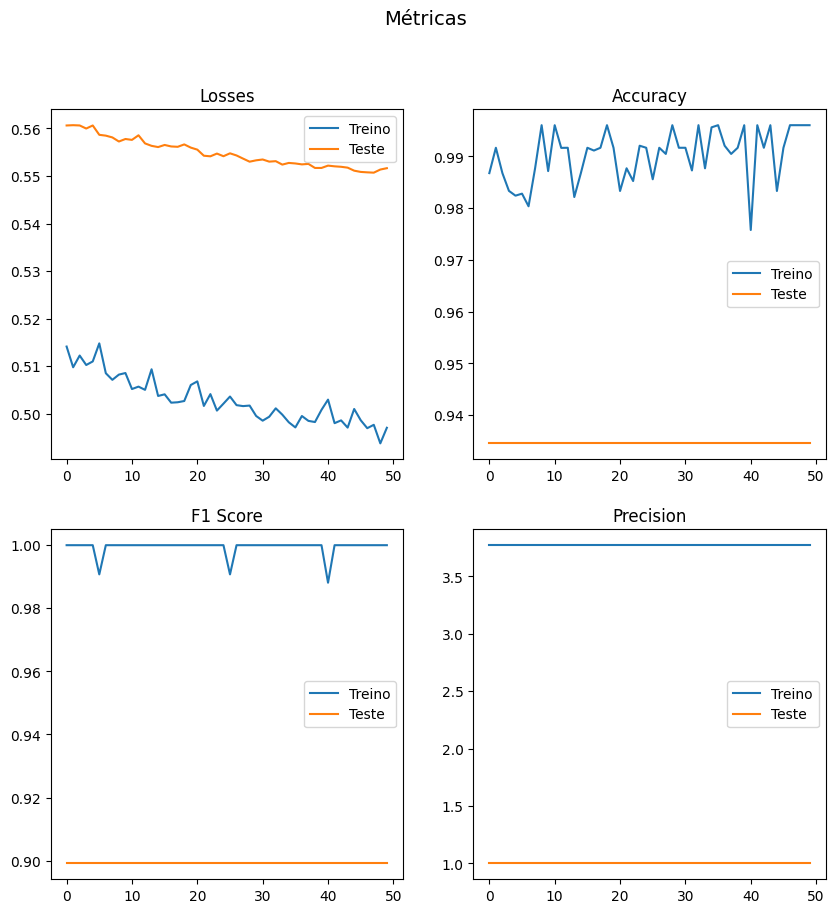

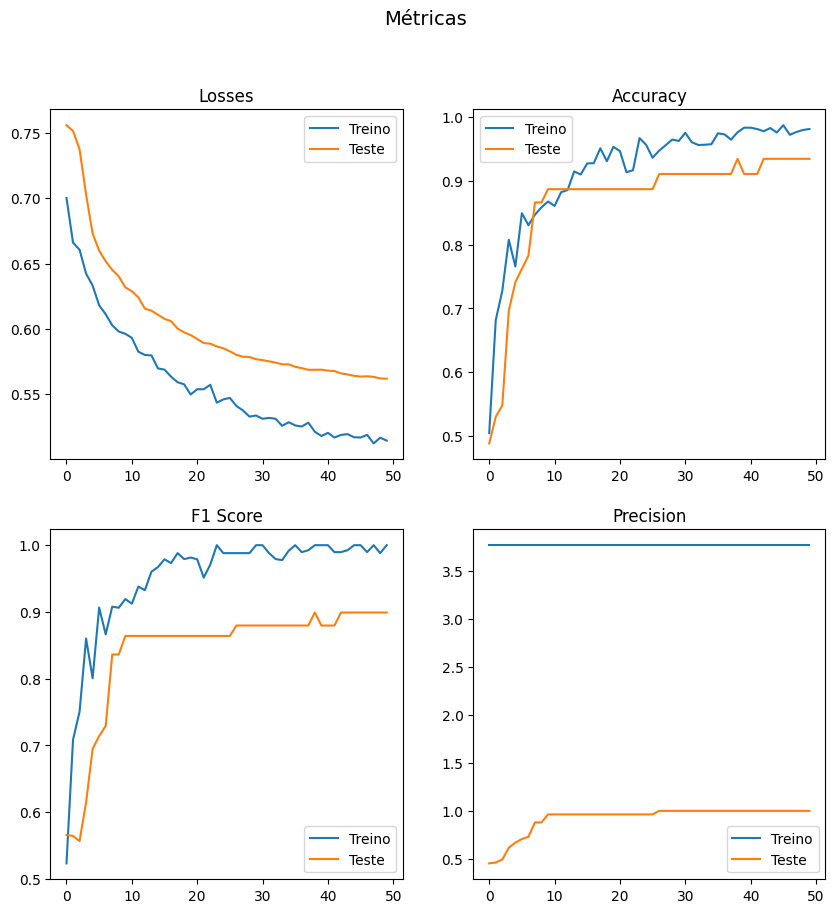

In [38]:

plot_graphs_scalar_metrics('BaselineAugmented', baseline_aug_train_losses, baseline_aug_test_losses, baseline_aug_train_accs, baseline_aug_test_accs, baseline_aug_train_f1s, baseline_aug_test_f1s, baseline_aug_train_precisions, baseline_aug_test_precisions)
plot_graphs_scalar_metrics('Baseline', baseline_train_losses, baseline_test_losses, baseline_train_accs, baseline_test_accs, baseline_train_f1s, baseline_test_f1s, baseline_train_precisions, baseline_test_precisions)

### DenseNet

In [39]:
class CustomDenseNet(nn.Module):
    def __init__(self):
        super(CustomDenseNet, self).__init__()
        self.base_model = models.densenet121(pretrained=True)
        for param in self.base_model.parameters():
            param.requires_grad = False
        num_ftrs = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.base_model(x)

In [40]:
model = CustomDenseNet()


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
model = model.to(device)

In [42]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

acc = Accuracy('binary', num_classes=2).to(device)
f1score = F1Score('binary', num_classes=2).to(device)
precision = Precision('binary', num_classes=2).to(device)
confusion_matrix = ConfusionMatrix('binary', num_classes=2).to(device)

In [43]:
baseline_train_losses, baseline_train_accs, baseline_train_f1s, baseline_train_precisions, baseline_train_confusion, baseline_test_losses, baseline_test_accs, baseline_test_f1s, baseline_test_precisions, baseline_test_confusion = workflow(model, train_loader, test_loader, criterion, optimizer, acc, f1score, precision, confusion_matrix, device, 50)
baseline_aug_train_losses, baseline_aug_train_accs, baseline_aug_train_f1s, baseline_aug_train_precisions, baseline_aug_train_confusion, baseline_aug_test_losses, baseline_aug_test_accs, baseline_aug_test_f1s, baseline_aug_test_precisions, baseline_aug_test_confusion = workflow(model, train_loader, test_loader, criterion, optimizer, acc, f1score, precision, confusion_matrix, device, 50)

  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:0.688911239306132, Train Acc:0.6576867351929346, Train_f1:0.5541552230715752, train_precision:3.7708333333333335, 

  2%|▏         | 1/50 [00:01<01:19,  1.62s/it]

Test Loss:0.6827429334322611, Test Acc:0.4434523781140645,  Test_f1:0.5862663884957632, train_precision:0.4460470179716746
Validation loss decreased (inf --> 0.682743). Saving model...
Train Loss:0.6361839522918066, Train Acc:0.7431277136007944, Train_f1:0.6487748473882675, train_precision:3.7708333333333335, 

  4%|▍         | 2/50 [00:02<01:09,  1.45s/it]

Test Loss:0.6512337128321329, Test Acc:0.699404756228129,  Test_f1:0.7198879718780518, train_precision:0.596801350514094
Validation loss decreased (0.682743 --> 0.651234). Saving model...
Train Loss:0.6012495706478754, Train Acc:0.7903076906998953, Train_f1:0.6996933668851852, train_precision:3.7708333333333335, 

  6%|▌         | 3/50 [00:04<01:05,  1.39s/it]

Test Loss:0.6214315295219421, Test Acc:0.7232142885526022,  Test_f1:0.7341736753781637, train_precision:0.6240740716457367
Validation loss decreased (0.651234 --> 0.621432). Saving model...
Train Loss:0.5673578977584839, Train Acc:0.8566161841154099, Train_f1:0.8190300514300665, train_precision:3.7708333333333335, 

  8%|▊         | 4/50 [00:05<01:03,  1.38s/it]

Test Loss:0.5783475637435913, Test Acc:0.8065476218859354,  Test_f1:0.7945054968198141, train_precision:0.6935185194015503
Validation loss decreased (0.621432 --> 0.578348). Saving model...
Train Loss:0.5258016635974249, Train Acc:0.8712060004472733, Train_f1:0.8224326620499293, train_precision:3.7708333333333335, 

 10%|█         | 5/50 [00:06<01:00,  1.35s/it]

Test Loss:0.54763795932134, Test Acc:0.8065476218859354,  Test_f1:0.7945054968198141, train_precision:0.6935185194015503
Validation loss decreased (0.578348 --> 0.547638). Saving model...
Train Loss:0.5178866758942604, Train Acc:0.8440883358319601, Train_f1:0.8215067386627197, train_precision:3.7708333333333335, 

 12%|█▏        | 6/50 [00:08<00:59,  1.34s/it]

Test Loss:0.5204642911752065, Test Acc:0.7648809552192688,  Test_f1:0.7647435863812765, train_precision:0.6598484814167023
Validation loss decreased (0.547638 --> 0.520464). Saving model...
Train Loss:0.47510896374781925, Train Acc:0.8907208094994227, Train_f1:0.8470749209324518, train_precision:3.7708333333333335, 

 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

Test Loss:0.4933120508988698, Test Acc:0.8065476218859354,  Test_f1:0.7945054968198141, train_precision:0.6935185194015503
Validation loss decreased (0.520464 --> 0.493312). Saving model...
Train Loss:0.4622516209880511, Train Acc:0.8900043914715449, Train_f1:0.8398989935715994, train_precision:3.7708333333333335, 

 16%|█▌        | 8/50 [00:10<00:56,  1.35s/it]

Test Loss:0.46417054533958435, Test Acc:0.8690476218859354,  Test_f1:0.855555534362793, train_precision:0.7761904795964559
Validation loss decreased (0.493312 --> 0.464171). Saving model...
Train Loss:0.4210781777898471, Train Acc:0.9252868145704269, Train_f1:0.892550508181254, train_precision:3.7708333333333335, 

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

Test Loss:0.44779204328854877, Test Acc:0.8690476218859354,  Test_f1:0.855555534362793, train_precision:0.7761904795964559
Validation loss decreased (0.464171 --> 0.447792). Saving model...
Train Loss:0.4150588388244311, Train Acc:0.8905781656503677, Train_f1:0.8583333343267441, train_precision:3.7708333333333335, 

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

Test Loss:0.42141329248746234, Test Acc:0.8898809552192688,  Test_f1:0.8808080752690634, train_precision:0.8158730069796244
Validation loss decreased (0.447792 --> 0.421413). Saving model...
Train Loss:0.37108730524778366, Train Acc:0.9391426543394724, Train_f1:0.9280723929405212, train_precision:3.7708333333333335, 

 22%|██▏       | 11/50 [00:15<00:53,  1.36s/it]

Test Loss:0.40246492624282837, Test Acc:0.8898809552192688,  Test_f1:0.8808080752690634, train_precision:0.8158730069796244
Validation loss decreased (0.421413 --> 0.402465). Saving model...
Train Loss:0.3542633168399334, Train Acc:0.9272175580263138, Train_f1:0.9146464665730795, train_precision:3.7708333333333335, 

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

Test Loss:0.3802547554175059, Test Acc:0.8898809552192688,  Test_f1:0.8808080752690634, train_precision:0.8158730069796244
Validation loss decreased (0.402465 --> 0.380255). Saving model...
Train Loss:0.34077083816130954, Train Acc:0.9310852388540903, Train_f1:0.911574070652326, train_precision:3.7708333333333335, 

 26%|██▌       | 13/50 [00:17<00:49,  1.34s/it]

Test Loss:0.3665866454442342, Test Acc:0.8898809552192688,  Test_f1:0.8808080752690634, train_precision:0.8158730069796244
Validation loss decreased (0.380255 --> 0.366587). Saving model...
Train Loss:0.3245640310148398, Train Acc:0.9391965866088867, Train_f1:0.9236111144224802, train_precision:3.7708333333333335, 

 28%|██▊       | 14/50 [00:19<00:48,  1.34s/it]

Test Loss:0.34405901034673053, Test Acc:0.8898809552192688,  Test_f1:0.8808080752690634, train_precision:0.8158730069796244
Validation loss decreased (0.366587 --> 0.344059). Saving model...
Train Loss:0.30636778846383095, Train Acc:0.9464308718840281, Train_f1:0.9323021918535233, train_precision:3.7708333333333335, 

 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

Test Loss:0.3291412989298503, Test Acc:0.8898809552192688,  Test_f1:0.8808080752690634, train_precision:0.8158730069796244
Validation loss decreased (0.344059 --> 0.329141). Saving model...
Train Loss:0.29716497162977856, Train Acc:0.9290379881858826, Train_f1:0.8810185243686041, train_precision:3.7708333333333335, 

 32%|███▏      | 16/50 [00:21<00:45,  1.33s/it]

Test Loss:0.3063390056292216, Test Acc:0.8898809552192688,  Test_f1:0.8808080752690634, train_precision:0.8158730069796244
Validation loss decreased (0.329141 --> 0.306339). Saving model...
Train Loss:0.28053634862105054, Train Acc:0.9450429032246271, Train_f1:0.9240319927533468, train_precision:3.7708333333333335, 

 34%|███▍      | 17/50 [00:23<00:43,  1.32s/it]

Test Loss:0.29452651739120483, Test Acc:0.8898809552192688,  Test_f1:0.8808080752690634, train_precision:0.8158730069796244
Validation loss decreased (0.306339 --> 0.294527). Saving model...
Train Loss:0.2623414744933446, Train Acc:0.95702030758063, Train_f1:0.9553872098525366, train_precision:3.7708333333333335, 

 36%|███▌      | 18/50 [00:24<00:42,  1.33s/it]

Test Loss:0.28215159972508747, Test Acc:0.8898809552192688,  Test_f1:0.8808080752690634, train_precision:0.8158730069796244
Validation loss decreased (0.294527 --> 0.282152). Saving model...
Train Loss:0.25069117546081543, Train Acc:0.9575649698575338, Train_f1:0.9546296298503876, train_precision:3.7708333333333335, 

 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

Test Loss:0.2636067221562068, Test Acc:0.9107142885526022,  Test_f1:0.9060606161753336, train_precision:0.855555534362793
Validation loss decreased (0.282152 --> 0.263607). Saving model...
Train Loss:0.24605775127808252, Train Acc:0.9520852814118067, Train_f1:0.9489057262738546, train_precision:3.7708333333333335, 

 40%|████      | 20/50 [00:27<00:40,  1.34s/it]

Test Loss:0.25929215053717297, Test Acc:0.913690467675527,  Test_f1:0.8982684016227722, train_precision:0.8189033269882202
Validation loss decreased (0.263607 --> 0.259292). Saving model...
Train Loss:0.22895119649668536, Train Acc:0.9466114242871603, Train_f1:0.9387205441792806, train_precision:3.7708333333333335, 

 42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

Test Loss:0.24567237496376038, Test Acc:0.9107142885526022,  Test_f1:0.9060606161753336, train_precision:0.855555534362793
Validation loss decreased (0.259292 --> 0.245672). Saving model...
Train Loss:0.21405229841669401, Train Acc:0.9702556033929189, Train_f1:0.9553872098525366, train_precision:3.7708333333333335, 

 44%|████▍     | 22/50 [00:29<00:38,  1.36s/it]

Test Loss:0.23453215758005777, Test Acc:0.9315476218859354,  Test_f1:0.9363636374473572, train_precision:0.9111110965410868
Validation loss decreased (0.245672 --> 0.234532). Saving model...
Train Loss:0.22051271796226501, Train Acc:0.9538800517717997, Train_f1:0.9389520237843195, train_precision:3.7708333333333335, 

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

Test Loss:0.2242054839928945, Test Acc:0.9553571343421936,  Test_f1:0.953823963801066, train_precision:0.9141414165496826
Validation loss decreased (0.234532 --> 0.224205). Saving model...
Train Loss:0.20341260358691216, Train Acc:0.961922268072764, Train_f1:0.963888888557752, train_precision:3.7708333333333335, 

 48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

Test Loss:0.21608375509579977, Test Acc:0.9553571343421936,  Test_f1:0.953823963801066, train_precision:0.9141414165496826
Validation loss decreased (0.224205 --> 0.216084). Saving model...
Train Loss:0.18241533264517784, Train Acc:0.9769685665766398, Train_f1:0.9646464685599009, train_precision:3.7708333333333335, 

 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

Test Loss:0.2048733780781428, Test Acc:0.976190467675527,  Test_f1:0.9841269850730896, train_precision:0.9696969787279764
Validation loss decreased (0.216084 --> 0.204873). Saving model...
Train Loss:0.1847640878210465, Train Acc:0.9770647684733073, Train_f1:0.9768518507480621, train_precision:3.7708333333333335, 

 52%|█████▏    | 26/50 [00:35<00:32,  1.35s/it]

Test Loss:0.20237287878990173, Test Acc:0.9553571343421936,  Test_f1:0.953823963801066, train_precision:0.9141414165496826
Validation loss decreased (0.204873 --> 0.202373). Saving model...
Train Loss:0.1790011739358306, Train Acc:0.9647000481685003, Train_f1:0.9634890606005987, train_precision:3.7708333333333335, 

 54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

Test Loss:0.18534700820843378, Test Acc:0.9523809552192688,  Test_f1:0.9666666587193807, train_precision:0.9666666587193807
Validation loss decreased (0.202373 --> 0.185347). Saving model...
Train Loss:0.17001233622431755, Train Acc:0.9837858229875565, Train_f1:0.9814814825852712, train_precision:3.7708333333333335, 

 56%|█████▌    | 28/50 [00:37<00:28,  1.29s/it]

Test Loss:0.18592684964338937, Test Acc:0.976190467675527,  Test_f1:0.9841269850730896, train_precision:0.9696969787279764
EarlyStopping counter: 1 out of 10
Train Loss:0.16290899241964021, Train Acc:0.9816059768199921, Train_f1:0.9924242446819941, train_precision:3.7708333333333335, 

 58%|█████▊    | 29/50 [00:39<00:27,  1.31s/it]

Test Loss:0.17431792865196863, Test Acc:0.976190467675527,  Test_f1:0.9841269850730896, train_precision:0.9696969787279764
Validation loss decreased (0.185347 --> 0.174318). Saving model...
Train Loss:0.1482290339966615, Train Acc:0.9851565212011337, Train_f1:0.9895833333333334, train_precision:3.7708333333333335, Test Loss:0.16700355211893717, Test Acc:0.976190467675527,  Test_f1:0.9841269850730896, train_precision:0.9696969787279764
Validation loss decreased (0.174318 --> 0.167004). Saving model...


 60%|██████    | 30/50 [00:40<00:27,  1.38s/it]

Train Loss:0.14244137269755205, Train Acc:0.9751167148351669, Train_f1:0.972748319307963, train_precision:3.7708333333333335, 

 62%|██████▏   | 31/50 [00:41<00:25,  1.36s/it]

Test Loss:0.16377859314282736, Test Acc:0.976190467675527,  Test_f1:0.9841269850730896, train_precision:0.9696969787279764
Validation loss decreased (0.167004 --> 0.163779). Saving model...
Train Loss:0.13701189526667198, Train Acc:0.9888888895511627, Train_f1:0.9895833333333334, train_precision:3.7708333333333335, 

 64%|██████▍   | 32/50 [00:43<00:24,  1.36s/it]

Test Loss:0.15473803877830505, Test Acc:0.976190467675527,  Test_f1:0.9841269850730896, train_precision:0.9696969787279764
Validation loss decreased (0.163779 --> 0.154738). Saving model...
Train Loss:0.13873890973627567, Train Acc:0.9846405237913132, Train_f1:0.9803240746259689, train_precision:3.7708333333333335, 

 66%|██████▌   | 33/50 [00:44<00:23,  1.36s/it]

Test Loss:0.15013528863588968, Test Acc:0.976190467675527,  Test_f1:0.9841269850730896, train_precision:0.9696969787279764
Validation loss decreased (0.154738 --> 0.150135). Saving model...
Train Loss:0.129675746584932, Train Acc:0.9790849685668945, Train_f1:0.9803240746259689, train_precision:3.7708333333333335, 

 68%|██████▊   | 34/50 [00:45<00:21,  1.36s/it]

Test Loss:0.14232192436854044, Test Acc:0.9523809552192688,  Test_f1:0.9666666587193807, train_precision:0.9666666587193807
Validation loss decreased (0.150135 --> 0.142322). Saving model...
Train Loss:0.1236902034531037, Train Acc:0.9715343763430914, Train_f1:0.9669612844785055, train_precision:3.7708333333333335, 

 70%|███████   | 35/50 [00:47<00:20,  1.37s/it]

Test Loss:0.13915315767129263, Test Acc:0.976190467675527,  Test_f1:0.9841269850730896, train_precision:0.9696969787279764
Validation loss decreased (0.142322 --> 0.139153). Saving model...
Train Loss:0.11278268167128165, Train Acc:0.9944444447755814, Train_f1:0.9895833333333334, train_precision:3.7708333333333335, 

 72%|███████▏  | 36/50 [00:48<00:18,  1.36s/it]

Test Loss:0.13386477530002594, Test Acc:0.976190467675527,  Test_f1:0.9841269850730896, train_precision:0.9696969787279764
Validation loss decreased (0.139153 --> 0.133865). Saving model...
Train Loss:0.10986517928540707, Train Acc:0.9911297857761383, Train_f1:0.9924242446819941, train_precision:3.7708333333333335, 

 74%|███████▍  | 37/50 [00:50<00:17,  1.38s/it]

Test Loss:0.13240696489810944, Test Acc:0.976190467675527,  Test_f1:0.9841269850730896, train_precision:0.9696969787279764
Validation loss decreased (0.133865 --> 0.132407). Saving model...
Train Loss:0.10416270575175683, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 76%|███████▌  | 38/50 [00:51<00:16,  1.37s/it]

Test Loss:0.12457980463902156, Test Acc:0.976190467675527,  Test_f1:0.9841269850730896, train_precision:0.9696969787279764
Validation loss decreased (0.132407 --> 0.124580). Saving model...
Train Loss:0.09762560265759627, Train Acc:0.9944444447755814, Train_f1:1.0, train_precision:3.7708333333333335, 

 78%|███████▊  | 39/50 [00:52<00:15,  1.38s/it]

Test Loss:0.1214597870906194, Test Acc:0.976190467675527,  Test_f1:0.9841269850730896, train_precision:0.9696969787279764
Validation loss decreased (0.124580 --> 0.121460). Saving model...
Train Loss:0.10307551672061284, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 80%|████████  | 40/50 [00:54<00:13,  1.37s/it]

Test Loss:0.11998021850983302, Test Acc:0.976190467675527,  Test_f1:0.9841269850730896, train_precision:0.9696969787279764
Validation loss decreased (0.121460 --> 0.119980). Saving model...
Train Loss:0.0902503514662385, Train Acc:0.9888888895511627, Train_f1:0.9895833333333334, train_precision:3.7708333333333335, 

 82%|████████▏ | 41/50 [00:55<00:12,  1.37s/it]

Test Loss:0.11348238587379456, Test Acc:0.976190467675527,  Test_f1:0.9841269850730896, train_precision:0.9696969787279764
Validation loss decreased (0.119980 --> 0.113482). Saving model...
Train Loss:0.09626803267747164, Train Acc:0.9960317462682724, Train_f1:1.0, train_precision:3.7708333333333335, 

 84%|████████▍ | 42/50 [00:56<00:10,  1.37s/it]

Test Loss:0.11122848714391391, Test Acc:0.976190467675527,  Test_f1:0.9841269850730896, train_precision:0.9696969787279764
Validation loss decreased (0.113482 --> 0.111228). Saving model...
Train Loss:0.09036238491535187, Train Acc:0.9895424842834473, Train_f1:0.9907407412926356, train_precision:3.7708333333333335, 

 86%|████████▌ | 43/50 [00:58<00:09,  1.37s/it]

Test Loss:0.1050490103662014, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.111228 --> 0.105049). Saving model...
Train Loss:0.0889492950712641, Train Acc:0.9944444447755814, Train_f1:1.0, train_precision:3.7708333333333335, 

 88%|████████▊ | 44/50 [00:59<00:07,  1.32s/it]

Test Loss:0.10614446798960368, Test Acc:0.976190467675527,  Test_f1:0.9841269850730896, train_precision:0.9696969787279764
EarlyStopping counter: 1 out of 10
Train Loss:0.08177375948677461, Train Acc:0.9950980395078659, Train_f1:0.9907407412926356, train_precision:3.7708333333333335, 

 90%|█████████ | 45/50 [01:00<00:06,  1.33s/it]

Test Loss:0.1012294168273608, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.105049 --> 0.101229). Saving model...
Train Loss:0.07315365457907319, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 92%|█████████▏| 46/50 [01:02<00:05,  1.33s/it]

Test Loss:0.0998535764714082, Test Acc:0.976190467675527,  Test_f1:0.9841269850730896, train_precision:0.9696969787279764
Validation loss decreased (0.101229 --> 0.099854). Saving model...
Train Loss:0.07413667533546686, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 94%|█████████▍| 47/50 [01:03<00:04,  1.34s/it]

Test Loss:0.09705392767985661, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.099854 --> 0.097054). Saving model...
Train Loss:0.06687404774129391, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

Test Loss:0.09380689511696498, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.097054 --> 0.093807). Saving model...
Train Loss:0.06944760649154584, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

Test Loss:0.09205312778552373, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.093807 --> 0.092053). Saving model...
Train Loss:0.07265766492734353, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


Test Loss:0.08850727727015813, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.092053 --> 0.088507). Saving model...


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss:0.06429732264950871, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

  2%|▏         | 1/50 [00:01<01:05,  1.34s/it]

Test Loss:0.08641476556658745, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (inf --> 0.086415). Saving model...
Train Loss:0.06704744913925727, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

  4%|▍         | 2/50 [00:02<01:05,  1.37s/it]

Test Loss:0.08501798287034035, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.086415 --> 0.085018). Saving model...
Train Loss:0.06043391736845175, Train Acc:0.9950980395078659, Train_f1:0.9907407412926356, train_precision:3.7708333333333335, 

  6%|▌         | 3/50 [00:04<01:03,  1.35s/it]

Test Loss:0.08147858455777168, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.085018 --> 0.081479). Saving model...
Train Loss:0.05384853528812528, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

  8%|▊         | 4/50 [00:05<01:02,  1.36s/it]

Test Loss:0.07954717924197514, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.081479 --> 0.079547). Saving model...
Train Loss:0.05221605456123749, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 10%|█         | 5/50 [00:06<01:01,  1.36s/it]

Test Loss:0.07847090562184651, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.079547 --> 0.078471). Saving model...
Train Loss:0.0511398334056139, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 12%|█▏        | 6/50 [00:08<01:00,  1.37s/it]

Test Loss:0.07500292733311653, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.078471 --> 0.075003). Saving model...
Train Loss:0.049403650065263115, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

Test Loss:0.073638416826725, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.075003 --> 0.073638). Saving model...
Train Loss:0.053111686992148556, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 16%|█▌        | 8/50 [00:10<00:57,  1.36s/it]

Test Loss:0.07136972372730573, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.073638 --> 0.071370). Saving model...
Train Loss:0.05286188346023361, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 18%|█▊        | 9/50 [00:12<00:55,  1.36s/it]

Test Loss:0.07063386651376884, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.071370 --> 0.070634). Saving model...
Train Loss:0.0473215968037645, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 20%|██        | 10/50 [00:13<00:54,  1.36s/it]

Test Loss:0.0697975680232048, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.070634 --> 0.069798). Saving model...
Train Loss:0.05058844666928053, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 22%|██▏       | 11/50 [00:14<00:53,  1.36s/it]

Test Loss:0.06928763662775357, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.069798 --> 0.069288). Saving model...
Train Loss:0.042460892194261156, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

Test Loss:0.06630393366018932, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.069288 --> 0.066304). Saving model...
Train Loss:0.04167503180603186, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 26%|██▌       | 13/50 [00:17<00:50,  1.37s/it]

Test Loss:0.06571808954079945, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.066304 --> 0.065718). Saving model...
Train Loss:0.041514321230351925, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 28%|██▊       | 14/50 [00:19<00:49,  1.36s/it]

Test Loss:0.0647475862254699, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.065718 --> 0.064748). Saving model...
Train Loss:0.03817947278730571, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 30%|███       | 15/50 [00:20<00:47,  1.35s/it]

Test Loss:0.06314748401443164, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.064748 --> 0.063147). Saving model...
Train Loss:0.03753891106074055, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 32%|███▏      | 16/50 [00:21<00:46,  1.36s/it]

Test Loss:0.06136107010145982, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.063147 --> 0.061361). Saving model...
Train Loss:0.03783207961047689, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 34%|███▍      | 17/50 [00:23<00:45,  1.37s/it]

Test Loss:0.05937720090150833, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.061361 --> 0.059377). Saving model...
Train Loss:0.03445930747936169, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 36%|███▌      | 18/50 [00:24<00:43,  1.36s/it]

Test Loss:0.05851719776789347, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.059377 --> 0.058517). Saving model...
Train Loss:0.036884665954858065, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 38%|███▊      | 19/50 [00:25<00:42,  1.36s/it]

Test Loss:0.057626535495122276, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.058517 --> 0.057627). Saving model...
Train Loss:0.03532546137770017, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 40%|████      | 20/50 [00:27<00:41,  1.37s/it]

Test Loss:0.056401277581850685, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.057627 --> 0.056401). Saving model...
Train Loss:0.02852667464564244, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 42%|████▏     | 21/50 [00:28<00:39,  1.38s/it]

Test Loss:0.05587180331349373, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.056401 --> 0.055872). Saving model...
Train Loss:0.03240203174451987, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 44%|████▍     | 22/50 [00:30<00:38,  1.38s/it]

Test Loss:0.05438121284047762, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.055872 --> 0.054381). Saving model...
Train Loss:0.028546219924464822, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 46%|████▌     | 23/50 [00:31<00:36,  1.36s/it]

Test Loss:0.05379534761110941, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.054381 --> 0.053795). Saving model...
Train Loss:0.03359306952916086, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 48%|████▊     | 24/50 [00:32<00:35,  1.38s/it]

Test Loss:0.052859801799058914, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.053795 --> 0.052860). Saving model...
Train Loss:0.026311318002020318, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 50%|█████     | 25/50 [00:34<00:34,  1.37s/it]

Test Loss:0.05180866333345572, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.052860 --> 0.051809). Saving model...
Train Loss:0.02685846434906125, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 52%|█████▏    | 26/50 [00:35<00:32,  1.36s/it]

Test Loss:0.05136894683043162, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.051809 --> 0.051369). Saving model...
Train Loss:0.0278836105329295, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 54%|█████▍    | 27/50 [00:36<00:31,  1.36s/it]

Test Loss:0.050575140863657, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.051369 --> 0.050575). Saving model...
Train Loss:0.027482836429650586, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 56%|█████▌    | 28/50 [00:38<00:29,  1.33s/it]

Test Loss:0.050580221538742386, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.02334106379809479, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 58%|█████▊    | 29/50 [00:39<00:27,  1.33s/it]

Test Loss:0.05008373719950517, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.050575 --> 0.050084). Saving model...
Train Loss:0.02824911739056309, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 60%|██████    | 30/50 [00:40<00:26,  1.34s/it]

Test Loss:0.049951089856525265, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.050084 --> 0.049951). Saving model...
Train Loss:0.023042492452077568, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, Test Loss:0.049291715336342655, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.049951 --> 0.049292). Saving model...


 62%|██████▏   | 31/50 [00:42<00:26,  1.37s/it]

Train Loss:0.02524308309269448, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 64%|██████▍   | 32/50 [00:43<00:24,  1.39s/it]

Test Loss:0.0486945907274882, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.049292 --> 0.048695). Saving model...
Train Loss:0.02223867007220785, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 66%|██████▌   | 33/50 [00:44<00:23,  1.38s/it]

Test Loss:0.047633968914548554, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.048695 --> 0.047634). Saving model...
Train Loss:0.022164811360804986, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 68%|██████▊   | 34/50 [00:46<00:21,  1.37s/it]

Test Loss:0.04701226204633713, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.047634 --> 0.047012). Saving model...
Train Loss:0.025250555636982124, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

Test Loss:0.047046790520350136, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.019827619194984436, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

Test Loss:0.04698102610806624, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.047012 --> 0.046981). Saving model...
Train Loss:0.020933232464206714, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 74%|███████▍  | 37/50 [00:50<00:17,  1.35s/it]

Test Loss:0.0466119758784771, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.046981 --> 0.046612). Saving model...
Train Loss:0.02394532427812616, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 76%|███████▌  | 38/50 [00:51<00:15,  1.30s/it]

Test Loss:0.046625010669231415, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.018860895186662674, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 78%|███████▊  | 39/50 [00:52<00:14,  1.32s/it]

Test Loss:0.04574220937987169, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.046612 --> 0.045742). Saving model...
Train Loss:0.01835986094859739, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 80%|████████  | 40/50 [00:54<00:13,  1.33s/it]

Test Loss:0.04461822658777237, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.045742 --> 0.044618). Saving model...
Train Loss:0.022408417503659923, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 82%|████████▏ | 41/50 [00:55<00:11,  1.33s/it]

Test Loss:0.04430462792515755, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.044618 --> 0.044305). Saving model...
Train Loss:0.019833101696955662, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 84%|████████▍ | 42/50 [00:56<00:10,  1.34s/it]

Test Loss:0.04356379838039478, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.044305 --> 0.043564). Saving model...
Train Loss:0.017291852505877614, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 86%|████████▌ | 43/50 [00:58<00:09,  1.35s/it]

Test Loss:0.04298080286631981, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.043564 --> 0.042981). Saving model...
Train Loss:0.017114773819533486, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 88%|████████▊ | 44/50 [00:59<00:08,  1.35s/it]

Test Loss:0.04275575031836828, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.042981 --> 0.042756). Saving model...
Train Loss:0.017677371234943468, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 90%|█████████ | 45/50 [01:00<00:06,  1.30s/it]

Test Loss:0.04306552776445945, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
EarlyStopping counter: 1 out of 10
Train Loss:0.015009261978169283, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 92%|█████████▏| 46/50 [01:02<00:05,  1.33s/it]

Test Loss:0.04231381633629402, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.042756 --> 0.042314). Saving model...
Train Loss:0.017001244084288675, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

Test Loss:0.04137039060393969, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.042314 --> 0.041370). Saving model...
Train Loss:0.015068132430315018, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

Test Loss:0.04075233141581217, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.041370 --> 0.040752). Saving model...
Train Loss:0.015552748266297082, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

 98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

Test Loss:0.040371412256111704, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.040752 --> 0.040371). Saving model...
Train Loss:0.015080363877738515, Train Acc:1.0, Train_f1:1.0, train_precision:3.7708333333333335, 

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

Test Loss:0.040138560657699905, Test Acc:1.0,  Test_f1:1.0, train_precision:1.0
Validation loss decreased (0.040371 --> 0.040139). Saving model...


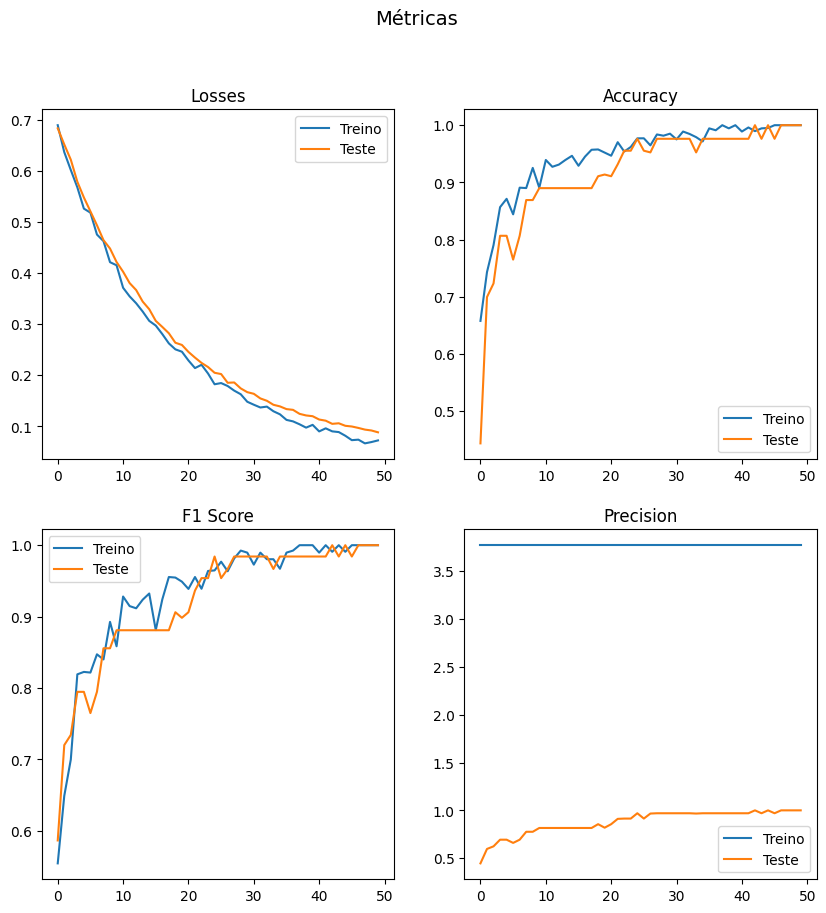

In [45]:

plot_graphs_scalar_metrics('Baseline', baseline_train_losses, baseline_test_losses, baseline_train_accs, baseline_test_accs, baseline_train_f1s, baseline_test_f1s, baseline_train_precisions, baseline_test_precisions)